<a href="https://colab.research.google.com/github/akbaradie/home-credit-scoring/blob/main/HC_App_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Akbar Adi Nugroho (akbaradie@gmail.com)

Acces my portfolios [HERE](https://akbaradie.github.io/)

## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

## Data Wrangling

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip 'drive/My Drive/Career/Internship/Rakamin Academy/01 Home Credit Indonesia Batch Jan 2024/Week 04/Final Project/home-credit-default-risk.zip' -d 'data/'

Archive:  drive/My Drive/Career/Internship/Rakamin Academy/01 Home Credit Indonesia Batch Jan 2024/Week 04/Final Project/home-credit-default-risk.zip
  inflating: data/HomeCredit_columns_description.csv  
  inflating: data/POS_CASH_balance.csv  
  inflating: data/application_test.csv  
  inflating: data/application_train.csv  
  inflating: data/bureau.csv         
  inflating: data/bureau_balance.csv  
  inflating: data/credit_card_balance.csv  
  inflating: data/installments_payments.csv  
  inflating: data/previous_application.csv  
  inflating: data/sample_submission.csv  


In [481]:
df_train = pd.read_csv('data/application_train.csv')
print('data shape:',df_train.shape)
df_train.head()

data shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,351000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,-3648.000,-2120,NaN,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,-1134.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,1129500.000,Family,State servant,Higher education,Married,House / apartment,0.004,-16765,-1188,-1186.000,-291,NaN,1,1,0,1,1,0,Core staff,2.000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311,0.622,NaN,0.096,0.053,0.985,0.796,0.060,0.080,0.035,0.292,0.333,0.013,0.077,0.055,0.004,0.010,0.092,0.054,0.985,0.804,0.050,0.081,0.035,0.292,0.333,0.013,0.079,0.055,0.000,0.000,0.097,0.053,0.985,0.799,0.061,0.080,0.035,0.292,0.333,0.013,0.079,0.056,0.004,0.010,reg oper account,block of flats,0.071,Block,No,1.000,0.000,1.000,0.000,-828.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,135000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010,-19046,-225,-4260.000,-2531,26.000,1,1,1,1,1,0,Laborers,1.000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.556,0.730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Exploratory Data Analysis (EDA)

In [482]:
print('Duplicated values: ', df_train.duplicated().sum())
print('Duplicated values in ID: ', df_train['SK_ID_CURR'].duplicated().sum())

Duplicated values:  0
Duplicated values in ID:  0


### Univariate Analysis

**Customers Payment Status**

In [483]:
df_train_trgt = df_train.copy()
df_train_trgt['TARGET'] = df_train['TARGET'].apply(lambda x: 'No Pay Difficulties' if x==0 else 'Pay Difficulties')

In [484]:
target_grp = df_train_trgt[['TARGET']].groupby("TARGET").agg(COUNT=("TARGET","count")).sort_values(by=["COUNT"],ascending=False).reset_index()
target_grp['%'] = target_grp['COUNT']/target_grp['COUNT'].sum()*100
target_grp

,TARGET,COUNT,%
0,No Pay Difficulties,282686,91.927
1,Pay Difficulties,24825,8.073


There are about 283K (92%) customer which had no prolbelms in repaying the loan in given time. Meanwhile for about 23K (8%) customers had problemms in repaying the loan.

TARGET is dependent (Y) variable and the dataset is imbalanced.

### Bivariate Analysis

In [485]:
cat = df_train.select_dtypes(include='object').columns
num = df_train.select_dtypes(include='number').columns

cat_in_num = []
for i in num:
  value_type = df_train[i].value_counts().shape[0]
  if value_type<4:
    cat_in_num.append(i)

num = [ x for x in num if x not in cat_in_num]
print('colum contain numeric non-categoric shape:',len(num))
print('colum contain categoric-numeric shape:',len(cat_in_num))
print('colum contain categoric-string shape:',len(cat))

colum contain numeric non-categoric shape: 71
colum contain categoric-numeric shape: 35
colum contain categoric-string shape: 16


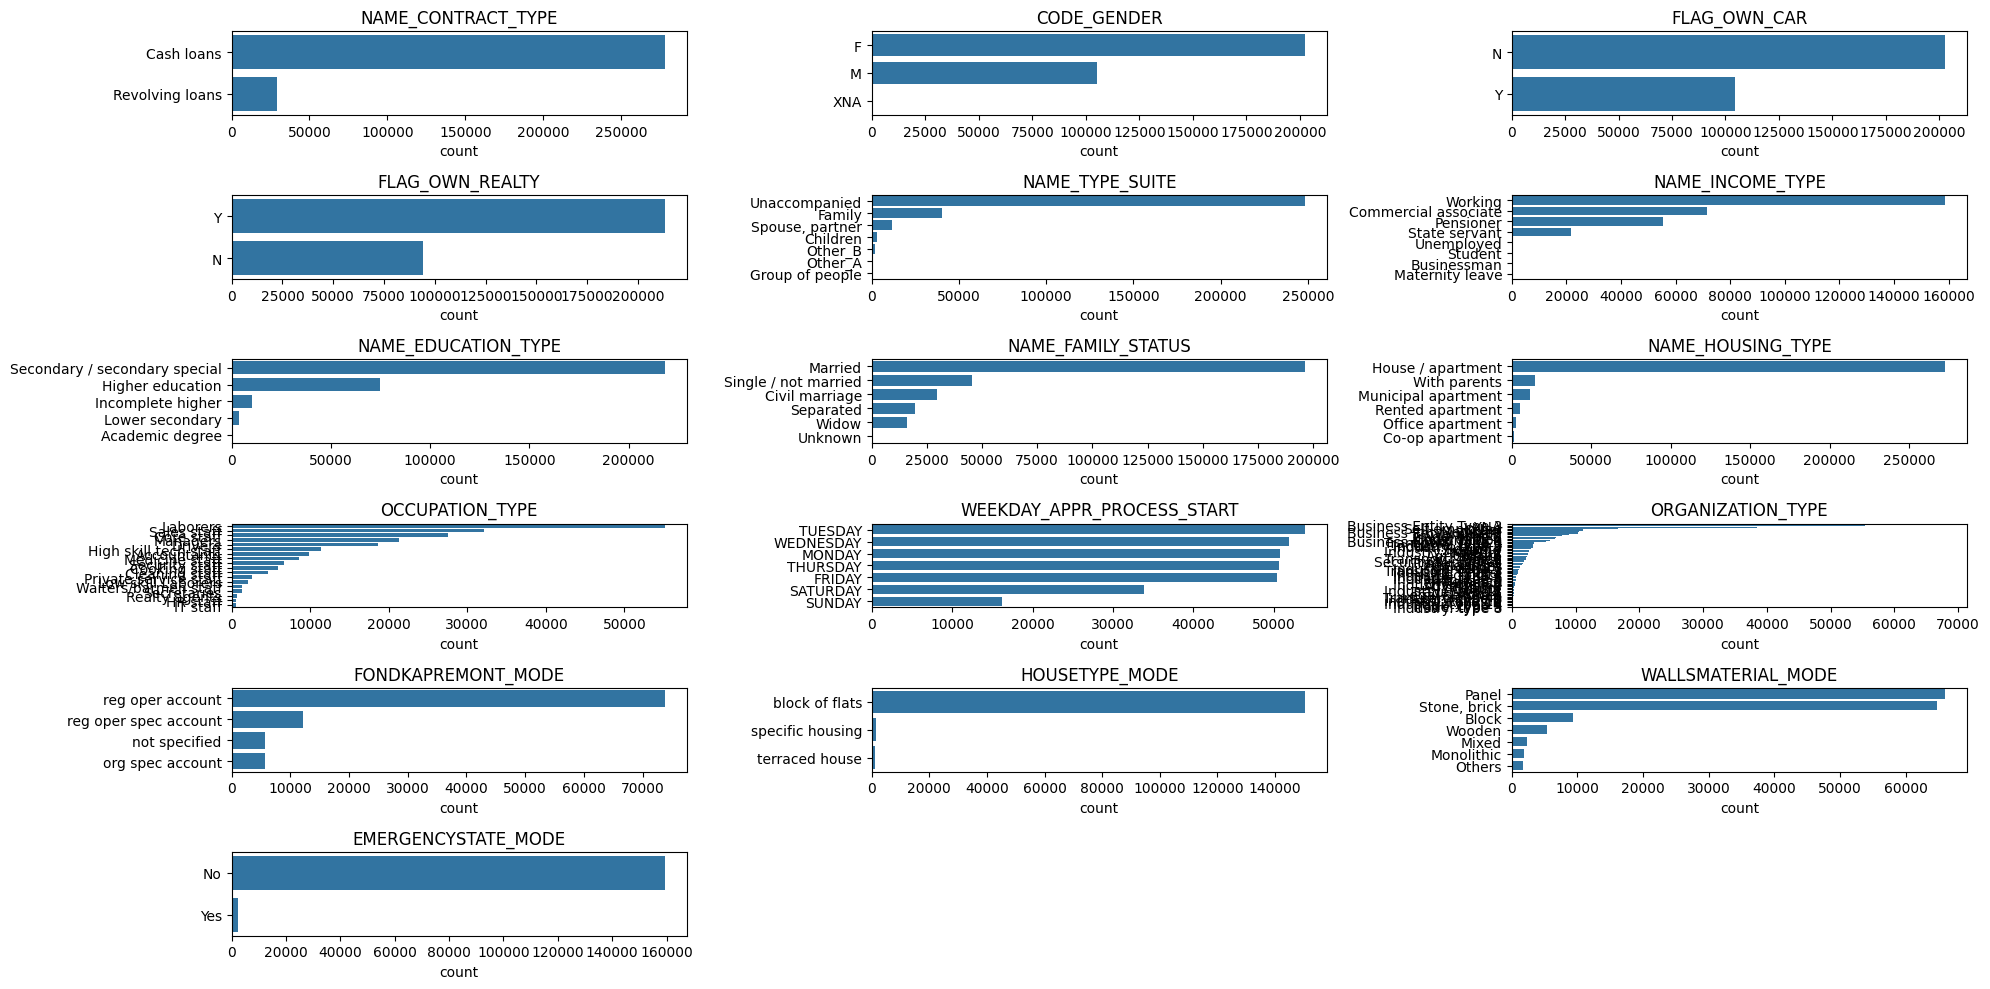

In [486]:
plt.figure(figsize=(20,10))
for i in range(0,len(cat)):
    plt.subplot(6,3,i+1)
    large_to_small = df_train.groupby(cat[i]).size().sort_values().index[::-1]
    sns.countplot(y=df_train[cat[i]], order=large_to_small,orient = 'h').set(ylabel='')
    plt.title(cat[i])
    plt.tight_layout()

There are imbalance data: HOUSETYPE_MODE, EMERGENCYSTATE_MODE

#### EDA in Categorical Columns

**Finding columns contain categorical values in both categorical (string) and numerical**

In [487]:
cat_in_num_twocat = []
for i in range(len(cat_in_num)):
  if df_train[cat_in_num[i]].value_counts().shape[0]==2 and cat_in_num[i] != 'TARGET':
    cat_in_num_twocat.append(cat_in_num[i])

print('There are',len(cat_in_num_twocat),'Categorical-numerical column contain 2 categories:\n',cat_in_num_twocat)

There are 32 Categorical-numerical column contain 2 categories:
 ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


In [488]:
cat_twocat = []
for i in range(len(cat)):
  if df_train[cat[i]].value_counts().shape[0]==2:
    cat_twocat.append(cat[i])

print('There are',len(cat_twocat),'Categorical column contain 2 categories:\n',cat_twocat)

There are 4 Categorical column contain 2 categories:
 ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']


##### 01 **Contract Type VS Target**

In [489]:
ct = df_train_trgt.groupby(by=['TARGET','NAME_CONTRACT_TYPE'], as_index=False)['SK_ID_CURR'].count()
ct['%'] = (ct['SK_ID_CURR']/ct['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
ct.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_CONTRACT_TYPE,SK_ID_CURR,%
0,No Pay Difficulties,Cash loans,255011,82.930
1,No Pay Difficulties,Revolving loans,27675,9.000
2,Pay Difficulties,Cash loans,23221,7.550
3,Pay Difficulties,Revolving loans,1604,0.520


<Axes: xlabel='NAME_CONTRACT_TYPE', ylabel='count'>

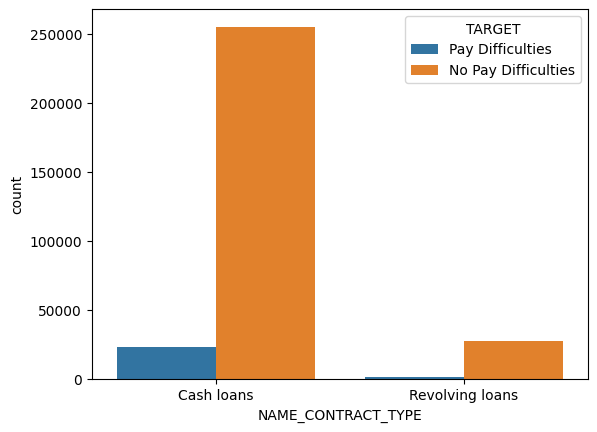

In [490]:
sns.countplot(data=df_train_trgt, x='NAME_CONTRACT_TYPE', hue='TARGET')

In [491]:
df_train[['NAME_CONTRACT_TYPE','TARGET']].groupby(['NAME_CONTRACT_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_CONTRACT_TYPE,TARGET
0,Cash loans,0.083
1,Revolving loans,0.055


Around 278K (90,5%) customers made cash loans which is accounted for the majority of total loans in this dataset. Meanwhile around 29K (9,5%) customers made revolving loans.

##### 02 **Gender VS Target**

In [492]:
gt = df_train_trgt.groupby(by=['TARGET','CODE_GENDER'], as_index=False)['SK_ID_CURR'].count()
gt['%'] = (gt['SK_ID_CURR']/gt['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Gender')
gt.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Gender


,TARGET,CODE_GENDER,SK_ID_CURR,%
0,No Pay Difficulties,F,188278,61.230
1,No Pay Difficulties,M,94404,30.700
3,Pay Difficulties,F,14170,4.610
4,Pay Difficulties,M,10655,3.460
2,No Pay Difficulties,XNA,4,0.000


<Axes: xlabel='CODE_GENDER', ylabel='count'>

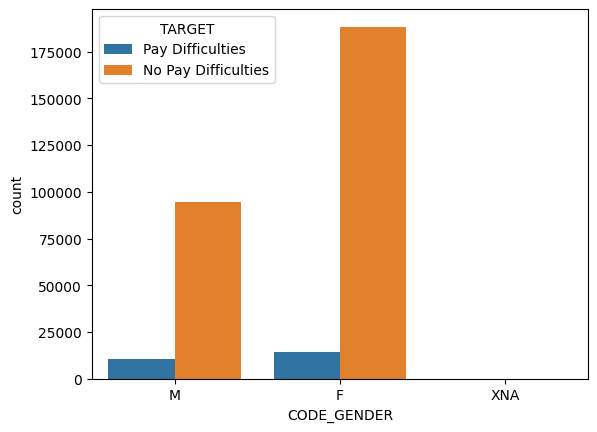

In [493]:
sns.countplot(data=df_train_trgt, x='CODE_GENDER', hue='TARGET')

In [494]:
df_train[['CODE_GENDER','TARGET']].groupby(['CODE_GENDER'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,CODE_GENDER,TARGET
1,M,0.101
0,F,0.070
2,XNA,0.000


Majority of clients is Female for about 202K (66%). Meanwhile Male customers is about 105K (34%). However, for about 10% of total men had the problems repaying the loan compared to women clients (about 7%).

In [495]:
df_train['CODE_GENDER'].replace({'XNA':'F'},inplace=True)
df_train['CODE_GENDER'].value_counts()

F    202452
M    105059
Name: CODE_GENDER, dtype: int64

##### 03 **Own Car vs Target**

In [496]:
oc = df_train_trgt.groupby(by=['TARGET','FLAG_OWN_CAR'], as_index=False)['SK_ID_CURR'].count()
oc['%'] = (oc['SK_ID_CURR']/oc['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
oc.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,FLAG_OWN_CAR,SK_ID_CURR,%
0,No Pay Difficulties,N,185675,60.380
1,No Pay Difficulties,Y,97011,31.550
2,Pay Difficulties,N,17249,5.610
3,Pay Difficulties,Y,7576,2.460


<Axes: xlabel='FLAG_OWN_CAR', ylabel='count'>

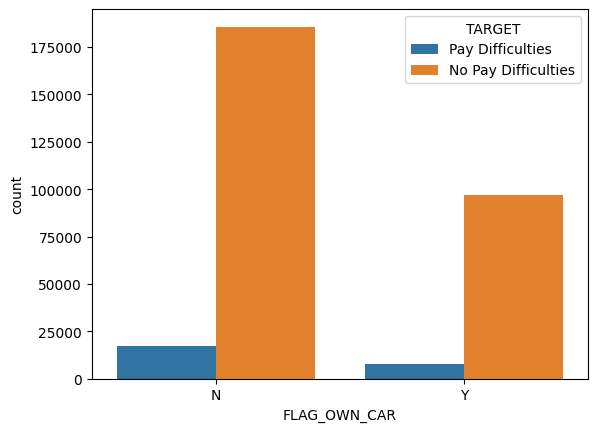

In [497]:
sns.countplot(data=df_train_trgt, x='FLAG_OWN_CAR', hue='TARGET')

In [498]:
df_train[['FLAG_OWN_CAR','TARGET']].groupby(['FLAG_OWN_CAR'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_CAR,TARGET
0,N,0.085
1,Y,0.072


Around 201K (66%) clients had no car and 8,5% of them had difficulty on paying loan. Meanwhile, around 7% of clients who had car had difficulty.

##### 04 **Own Realty vs Target**

In [499]:
orealty = df_train_trgt.groupby(by=['TARGET','FLAG_OWN_REALTY'], as_index=False)['SK_ID_CURR'].count()
orealty['%'] = (orealty['SK_ID_CURR']/orealty['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
orealty.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,FLAG_OWN_REALTY,SK_ID_CURR,%
1,No Pay Difficulties,Y,196329,63.840
0,No Pay Difficulties,N,86357,28.080
3,Pay Difficulties,Y,16983,5.520
2,Pay Difficulties,N,7842,2.550


<Axes: xlabel='FLAG_OWN_REALTY', ylabel='count'>

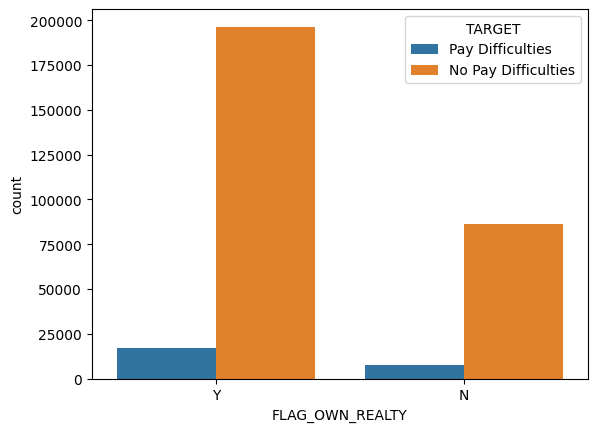

In [500]:
sns.countplot(data=df_train_trgt, x='FLAG_OWN_REALTY', hue='TARGET')

In [501]:
df_train[['FLAG_OWN_REALTY','TARGET']].groupby(['FLAG_OWN_REALTY'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_REALTY,TARGET
0,N,0.083
1,Y,0.080


Around 213K (69%) clients own realty, but 8,5% of them had difficulty on paying loan. Meanwhile, around 8% of clients who had no realty had no difficulty.

##### 05 **Emergency State Mode VS Target**

In [502]:
emergency = df_train_trgt.groupby(by=['TARGET','EMERGENCYSTATE_MODE'], as_index=False)['SK_ID_CURR'].count()
emergency['%'] = (emergency['SK_ID_CURR']/emergency['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
emergency.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,EMERGENCYSTATE_MODE,SK_ID_CURR,%
0,No Pay Difficulties,No,148324,91.700
2,Pay Difficulties,No,11104,6.860
1,No Pay Difficulties,Yes,2105,1.300
3,Pay Difficulties,Yes,223,0.140


<Axes: xlabel='EMERGENCYSTATE_MODE', ylabel='count'>

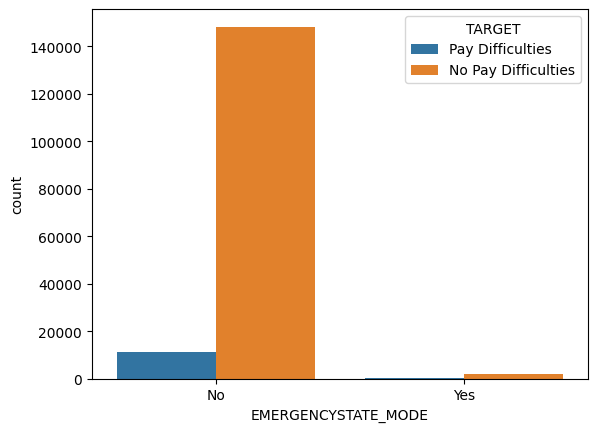

In [503]:
sns.countplot(data=df_train_trgt, x='EMERGENCYSTATE_MODE', hue='TARGET')

In [504]:
df_train[['EMERGENCYSTATE_MODE','TARGET']].groupby(['EMERGENCYSTATE_MODE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,EMERGENCYSTATE_MODE,TARGET
1,Yes,0.096
0,No,0.070


Around 2K (1,4%) clients had emergency state and 9,5% of them had difficulty on paying loan. Meanwhile, around 7% of clients who had no emergency state had no difficulty.

##### 06 **Name Type Suite VS Target**

In [505]:
type_suite = df_train_trgt.groupby(by=['TARGET','NAME_TYPE_SUITE'], as_index=False)['SK_ID_CURR'].count()
type_suite['%'] = (type_suite['SK_ID_CURR']/type_suite['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
type_suite.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_TYPE_SUITE,SK_ID_CURR,%
6,No Pay Difficulties,Unaccompanied,228189,74.520
1,No Pay Difficulties,Family,37140,12.130
13,Pay Difficulties,Unaccompanied,20337,6.640
5,No Pay Difficulties,"Spouse, partner",10475,3.420
0,No Pay Difficulties,Children,3026,0.990
8,Pay Difficulties,Family,3009,0.980
4,No Pay Difficulties,Other_B,1596,0.520
12,Pay Difficulties,"Spouse, partner",895,0.290
3,No Pay Difficulties,Other_A,790,0.260
2,No Pay Difficulties,Group of people,248,0.080


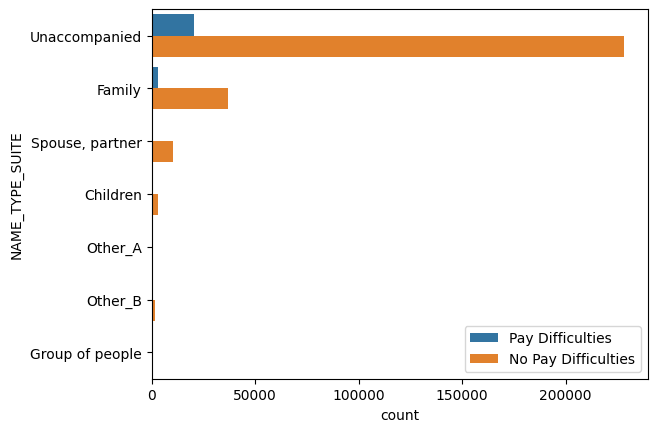

In [506]:
sns.countplot(data=df_train_trgt, y='NAME_TYPE_SUITE', hue='TARGET')
plt.legend(loc='lower right')

In [507]:
df_train[['NAME_TYPE_SUITE','TARGET']].groupby(['NAME_TYPE_SUITE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_TYPE_SUITE,TARGET
4,Other_B,0.098
3,Other_A,0.088
2,Group of people,0.085
6,Unaccompanied,0.082
5,"Spouse, partner",0.079
1,Family,0.075
0,Children,0.074


Majority of clients was unaccompanied when applied for loans (about 248K or 81% of total) and 8,1% of them had difficulty on paying the loans. Meanwhile, clients who accompanied by Other_A and other_B are less than 1% respectively. But, around 8-10% of them had difficulty on paying the loans.

**Merge Other_A & Other_B**

In [508]:
categories_to_merge = ['Other', 'Trade', 'Industry']

df_train_suite = df_train_trgt.copy()

df_train_suite['NAME_TYPE_SUITE'] = df_train_suite['NAME_TYPE_SUITE'].replace({'Other_A':'Other', 'Other_B':'Other'})

In [509]:
suite = df_train_suite.groupby(by=['TARGET','NAME_TYPE_SUITE'], as_index=False)['SK_ID_CURR'].count()
suite['%'] = (suite['SK_ID_CURR']/suite['SK_ID_CURR'].sum()*100).round(4)
print('Clients Repayment Abilities By Contract Type')
suite.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_TYPE_SUITE,SK_ID_CURR,%
5,No Pay Difficulties,Unaccompanied,228189,74.518
1,No Pay Difficulties,Family,37140,12.129
11,Pay Difficulties,Unaccompanied,20337,6.641
4,No Pay Difficulties,"Spouse, partner",10475,3.421
0,No Pay Difficulties,Children,3026,0.988
7,Pay Difficulties,Family,3009,0.983
3,No Pay Difficulties,Other,2386,0.779
10,Pay Difficulties,"Spouse, partner",895,0.292
9,Pay Difficulties,Other,250,0.082
2,No Pay Difficulties,Group of people,248,0.081


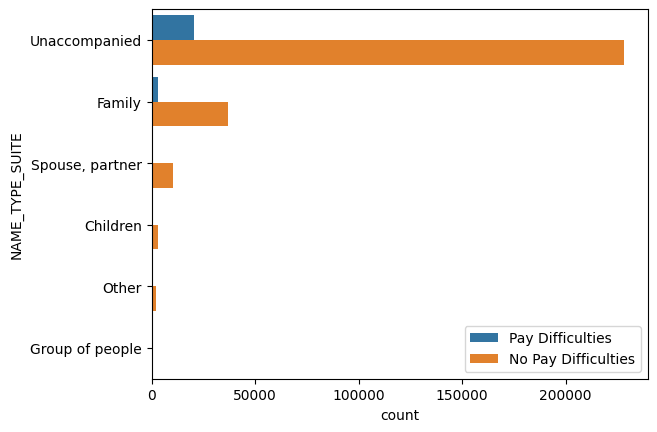

In [510]:
sns.countplot(data=df_train_suite, y='NAME_TYPE_SUITE', hue='TARGET')
plt.legend(loc='lower right')

In [511]:
df_train_suite['TARGET'] = df_train['TARGET']
df_train_suite[['NAME_TYPE_SUITE','TARGET']].groupby(['NAME_TYPE_SUITE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_TYPE_SUITE,TARGET
3,Other,0.095
2,Group of people,0.085
5,Unaccompanied,0.082
4,"Spouse, partner",0.079
1,Family,0.075
0,Children,0.074


##### 07 **Income Type VS Target**

In [512]:
income = df_train_trgt.groupby(by=['NAME_INCOME_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
income['%'] = (income['SK_ID_CURR']/income['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
income.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,NAME_INCOME_TYPE,TARGET,SK_ID_CURR,%
12,Working,No Pay Difficulties,143550,46.680
1,Commercial associate,No Pay Difficulties,66257,21.550
5,Pensioner,No Pay Difficulties,52380,17.030
7,State servant,No Pay Difficulties,20454,6.650
13,Working,Pay Difficulties,15224,4.950
2,Commercial associate,Pay Difficulties,5360,1.740
6,Pensioner,Pay Difficulties,2982,0.970
8,State servant,Pay Difficulties,1249,0.410
9,Student,No Pay Difficulties,18,0.010
10,Unemployed,No Pay Difficulties,14,0.000


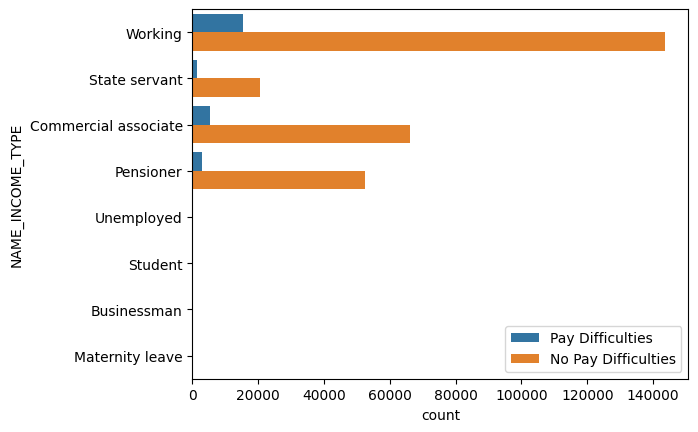

In [513]:
sns.countplot(data=df_train_trgt, y='NAME_INCOME_TYPE', hue='TARGET')
plt.legend(loc='lower right')

In [514]:
df_train[['NAME_INCOME_TYPE','TARGET']].groupby(['NAME_INCOME_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_INCOME_TYPE,TARGET
2,Maternity leave,0.400
6,Unemployed,0.364
7,Working,0.096
1,Commercial associate,0.075
4,State servant,0.058
3,Pensioner,0.054
0,Businessman,0.000
5,Student,0.000


Client who have working as income type have applied for majority of loans, around 158K (51%). But, around 10% of them have difficulty in paying loans. Client who have Businessman and Studnet as income type are almost 0% of total clients, but they have no difficulty in paying loans.

The highest proportion of type that have difficulty in paying loans are Maternity leave and Unemployed which is 40% and 36% respectively. But, there is only 5 and 22 client with maternity leave and unemployed respectively.

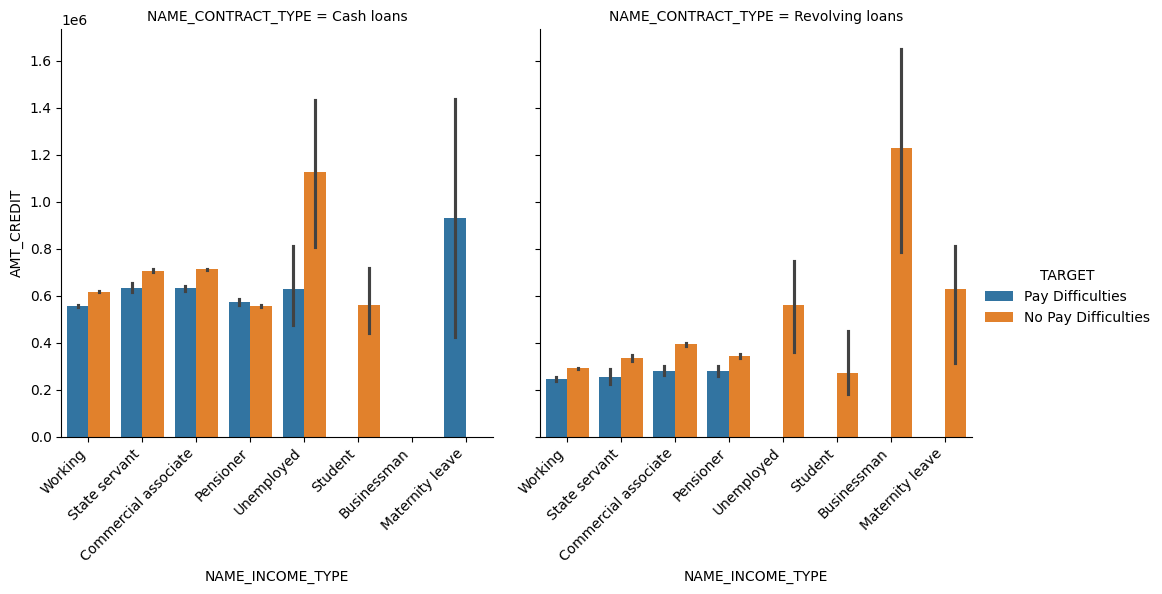

In [515]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
                  y = 'AMT_CREDIT',
                  hue = 'TARGET',
                  col = 'NAME_CONTRACT_TYPE',
                  kind = 'bar',
                  data = df_train_trgt)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [516]:
df_train_trgt.groupby(by=['NAME_INCOME_TYPE','NAME_CONTRACT_TYPE', 'TARGET'], as_index=False)['SK_ID_CURR'].count()

,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,TARGET,SK_ID_CURR
0,Businessman,Revolving loans,No Pay Difficulties,10
1,Commercial associate,Cash loans,No Pay Difficulties,58662
2,Commercial associate,Cash loans,Pay Difficulties,4990
3,Commercial associate,Revolving loans,No Pay Difficulties,7595
4,Commercial associate,Revolving loans,Pay Difficulties,370
5,Maternity leave,Cash loans,Pay Difficulties,2
6,Maternity leave,Revolving loans,No Pay Difficulties,3
7,Pensioner,Cash loans,No Pay Difficulties,49151
8,Pensioner,Cash loans,Pay Difficulties,2842
9,Pensioner,Revolving loans,No Pay Difficulties,3229


##### 08 **Education Type VS Target**

In [517]:
edu_type = df_train_trgt.groupby(by=['TARGET','NAME_EDUCATION_TYPE'], as_index=False)['SK_ID_CURR'].count()
edu_type['%'] = (edu_type['SK_ID_CURR']/edu_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
edu_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_EDUCATION_TYPE,SK_ID_CURR,%
4,No Pay Difficulties,Secondary / secondary special,198867,64.670
1,No Pay Difficulties,Higher education,70854,23.040
9,Pay Difficulties,Secondary / secondary special,19524,6.350
2,No Pay Difficulties,Incomplete higher,9405,3.060
6,Pay Difficulties,Higher education,4009,1.300
3,No Pay Difficulties,Lower secondary,3399,1.110
7,Pay Difficulties,Incomplete higher,872,0.280
8,Pay Difficulties,Lower secondary,417,0.140
0,No Pay Difficulties,Academic degree,161,0.050
5,Pay Difficulties,Academic degree,3,0.000


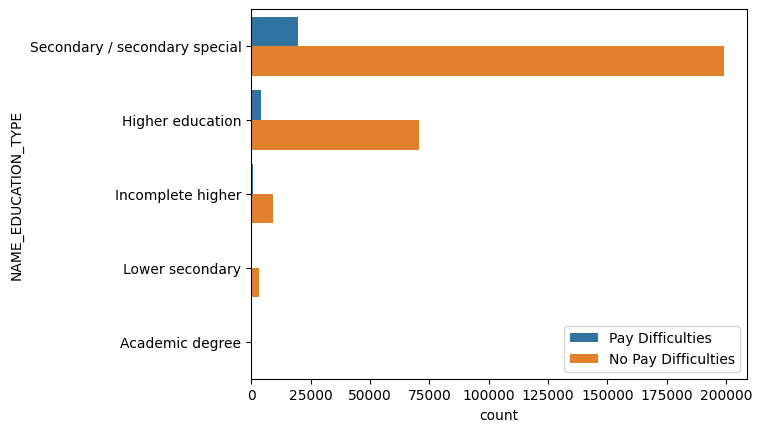

In [518]:
sns.countplot(data=df_train_trgt, y='NAME_EDUCATION_TYPE', hue='TARGET')
plt.legend(loc='lower right')

In [519]:
df_train[['NAME_EDUCATION_TYPE','TARGET']].groupby(['NAME_EDUCATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_EDUCATION_TYPE,TARGET
3,Lower secondary,0.109
4,Secondary / secondary special,0.089
2,Incomplete higher,0.085
1,Higher education,0.054
0,Academic degree,0.018


Most of the clients' education type are Secondary and higher education which is around 218K (71%) and 75K (24%) respectively. But 9% of clients with lower secondary as education type have difficulty in paying loans. Meanwhile, client's education type with the highest rate of having difficulty in paying loans is lower secondary (11%)

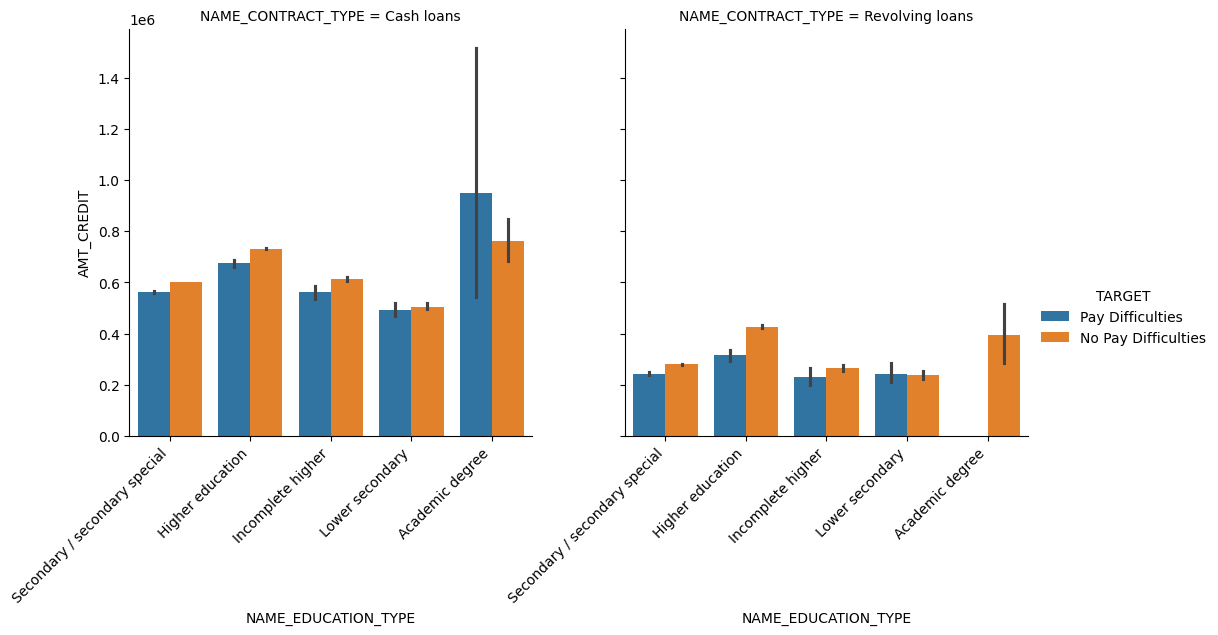

In [520]:
fig = sns.catplot(x = 'NAME_EDUCATION_TYPE',
                  y = 'AMT_CREDIT',
                  hue = 'TARGET',
                  col = 'NAME_CONTRACT_TYPE',
                  kind = 'bar',
                  data = df_train_trgt)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

##### 09 **Family Status VS Target**

In [521]:
family_stat = df_train_trgt.groupby(by=['TARGET','NAME_FAMILY_STATUS'], as_index=False)['SK_ID_CURR'].count()
family_stat['%'] = (family_stat['SK_ID_CURR']/family_stat['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
family_stat.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_FAMILY_STATUS,SK_ID_CURR,%
1,No Pay Difficulties,Married,181582,59.050
3,No Pay Difficulties,Single / not married,40987,13.330
0,No Pay Difficulties,Civil marriage,26814,8.720
2,No Pay Difficulties,Separated,18150,5.900
5,No Pay Difficulties,Widow,15151,4.930
7,Pay Difficulties,Married,14850,4.830
9,Pay Difficulties,Single / not married,4457,1.450
6,Pay Difficulties,Civil marriage,2961,0.960
8,Pay Difficulties,Separated,1620,0.530
10,Pay Difficulties,Widow,937,0.300


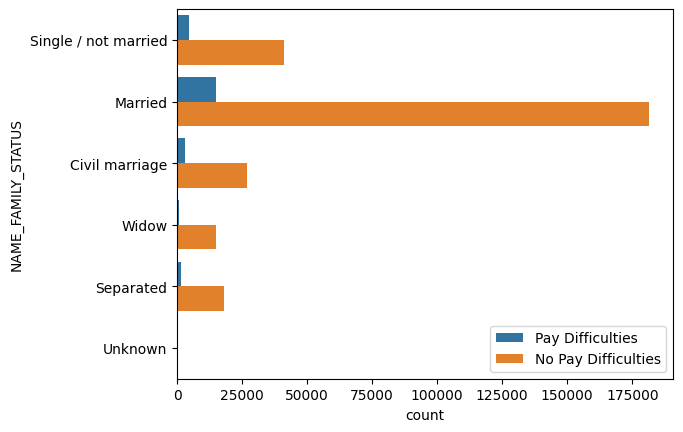

In [522]:
sns.countplot(data=df_train_trgt, y='NAME_FAMILY_STATUS', hue='TARGET')
plt.legend(loc='lower right')

In [523]:
df_train[['NAME_FAMILY_STATUS','TARGET']].groupby(['NAME_FAMILY_STATUS'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_FAMILY_STATUS,TARGET
0,Civil marriage,0.099
3,Single / not married,0.098
2,Separated,0.082
1,Married,0.076
5,Widow,0.058
4,Unknown,0.000


Most clients have married and followed by single which is around 196K (64%) and 45K (14%). Around 10% of Civil marriage and single clients have difficulty in paying loans.

In [524]:
#df_train['NAME_FAMILY_STATUS'].replace({'Unknown':np.nan},inplace=True)

##### 10 **Housing Type VS Target**

In [525]:
house_type = df_train_trgt.groupby(by=['TARGET','NAME_HOUSING_TYPE'], as_index=False)['SK_ID_CURR'].count()
house_type['%'] = (house_type['SK_ID_CURR']/house_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
house_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,NAME_HOUSING_TYPE,SK_ID_CURR,%
1,No Pay Difficulties,House / apartment,251596,81.820
7,Pay Difficulties,House / apartment,21272,6.920
5,No Pay Difficulties,With parents,13104,4.260
2,No Pay Difficulties,Municipal apartment,10228,3.330
4,No Pay Difficulties,Rented apartment,4280,1.390
3,No Pay Difficulties,Office apartment,2445,0.800
11,Pay Difficulties,With parents,1736,0.560
0,No Pay Difficulties,Co-op apartment,1033,0.340
8,Pay Difficulties,Municipal apartment,955,0.310
10,Pay Difficulties,Rented apartment,601,0.200


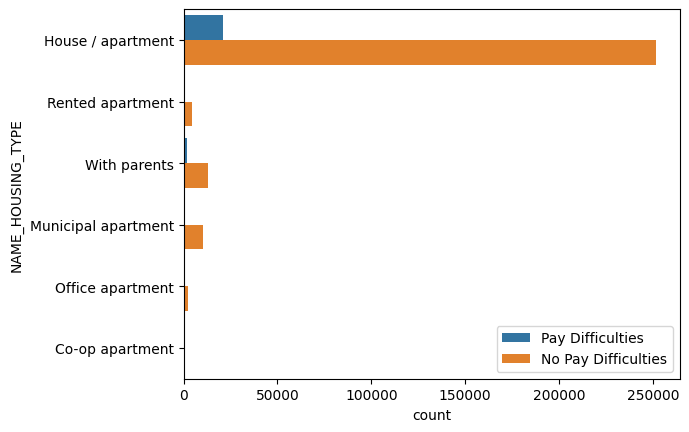

In [526]:
sns.countplot(data=df_train_trgt, y='NAME_HOUSING_TYPE', hue='TARGET')
plt.legend(loc='lower right')

In [527]:
df_train[['NAME_HOUSING_TYPE','TARGET']].groupby(['NAME_HOUSING_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_HOUSING_TYPE,TARGET
4,Rented apartment,0.123
5,With parents,0.117
2,Municipal apartment,0.085
0,Co-op apartment,0.079
1,House / apartment,0.078
3,Office apartment,0.066


Most of clients have house, around 273K (88%). Clients who living in rented apartment and with parents were only around 5K (1,5%) and 15K (5%) respectively. But, 12% and 11% of them are having difficulty in paying loans.

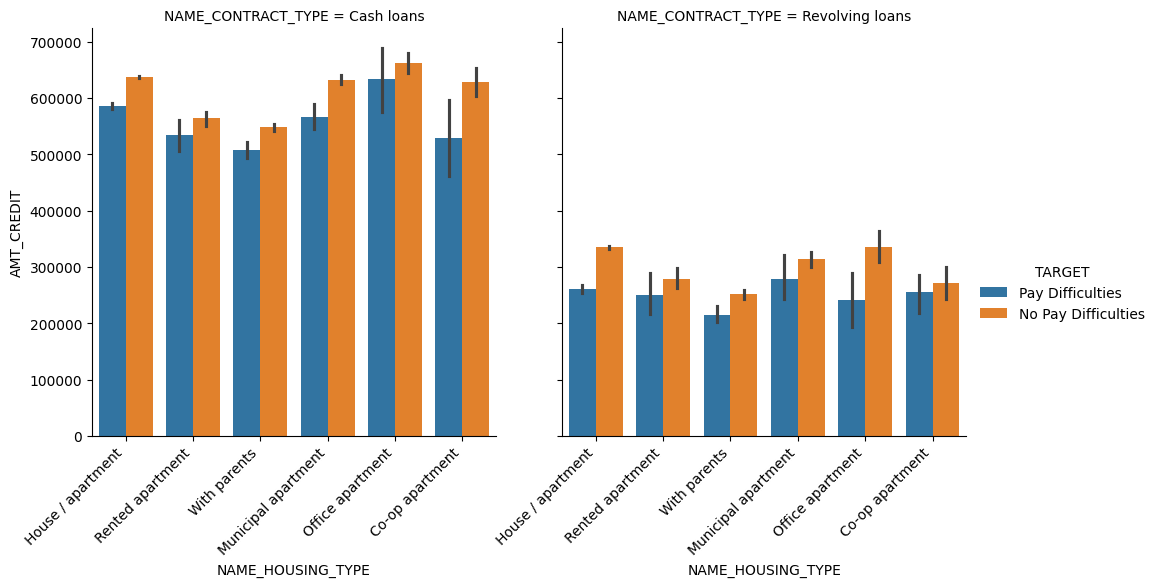

In [528]:
fig = sns.catplot(x = 'NAME_HOUSING_TYPE',
                  y = 'AMT_CREDIT',
                  hue = 'TARGET',
                  col = 'NAME_CONTRACT_TYPE',
                  kind = 'bar',
                  data = df_train_trgt)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

##### 11 **Occupation Type VS Target**

In [529]:
occup_type = df_train_trgt.groupby(by=['TARGET','OCCUPATION_TYPE'], as_index=False)['SK_ID_CURR'].count()
occup_type['%'] = (occup_type['SK_ID_CURR']/occup_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
occup_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,OCCUPATION_TYPE,SK_ID_CURR,%
8,No Pay Difficulties,Laborers,49348,23.370
14,No Pay Difficulties,Sales staff,29010,13.740
3,No Pay Difficulties,Core staff,25832,12.240
10,No Pay Difficulties,Managers,20043,9.490
4,No Pay Difficulties,Drivers,16496,7.810
6,No Pay Difficulties,High skill tech staff,10679,5.060
0,No Pay Difficulties,Accountants,9339,4.420
11,No Pay Difficulties,Medicine staff,7965,3.770
16,No Pay Difficulties,Security staff,5999,2.840
26,Pay Difficulties,Laborers,5838,2.770


<Axes: xlabel='count', ylabel='OCCUPATION_TYPE'>

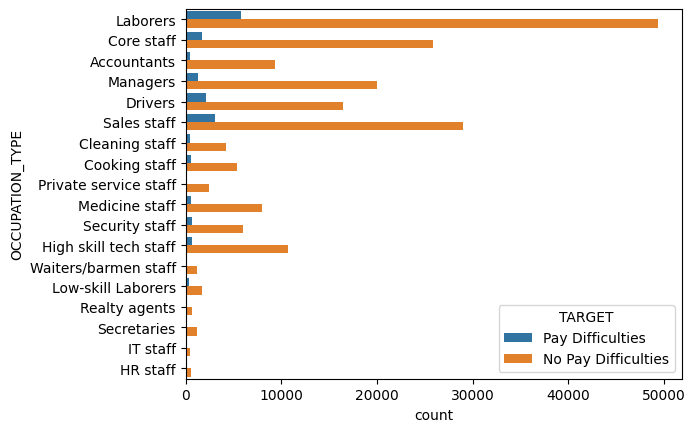

In [530]:
sns.countplot(data=df_train_trgt, y='OCCUPATION_TYPE', hue='TARGET')

In [531]:
df_train[['OCCUPATION_TYPE','TARGET']].groupby(['OCCUPATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,OCCUPATION_TYPE,TARGET
9,Low-skill Laborers,0.172
4,Drivers,0.113
17,Waiters/barmen staff,0.113
16,Security staff,0.107
8,Laborers,0.106
2,Cooking staff,0.104
14,Sales staff,0.096
1,Cleaning staff,0.096
13,Realty agents,0.079
15,Secretaries,0.070


<Figure size 2000x1000 with 0 Axes>

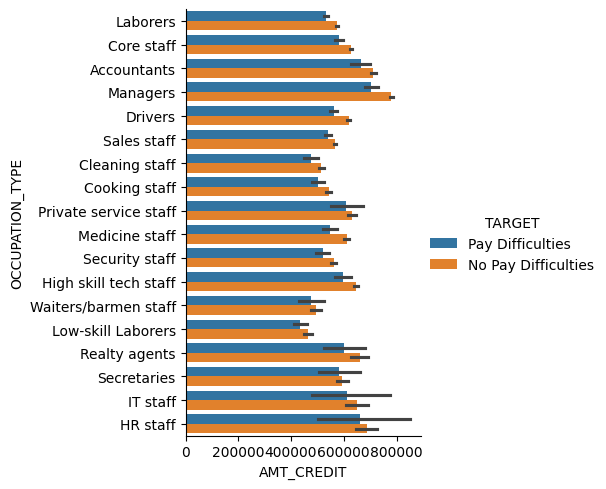

In [532]:
plt.figure(figsize=(20, 10))
fig = sns.catplot(y = 'OCCUPATION_TYPE',
                  x = 'AMT_CREDIT',
                  hue = 'TARGET',
                  # col = 'NAME_CONTRACT_TYPE',
                  kind = 'bar',
                  data = df_train_trgt)

#fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

##### 12 **Weekday App VS Target**

In [533]:
weekday_app = df_train_trgt.groupby(by=['TARGET','WEEKDAY_APPR_PROCESS_START'], as_index=False)['SK_ID_CURR'].count()
weekday_app['%'] = (weekday_app['SK_ID_CURR']/weekday_app['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
weekday_app.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,WEEKDAY_APPR_PROCESS_START,SK_ID_CURR,%
5,No Pay Difficulties,TUESDAY,49400,16.060
6,No Pay Difficulties,WEDNESDAY,47696,15.510
1,No Pay Difficulties,MONDAY,46780,15.210
4,No Pay Difficulties,THURSDAY,46493,15.120
0,No Pay Difficulties,FRIDAY,46237,15.040
2,No Pay Difficulties,SATURDAY,31182,10.140
3,No Pay Difficulties,SUNDAY,14898,4.840
12,Pay Difficulties,TUESDAY,4501,1.460
13,Pay Difficulties,WEDNESDAY,4238,1.380
7,Pay Difficulties,FRIDAY,4101,1.330


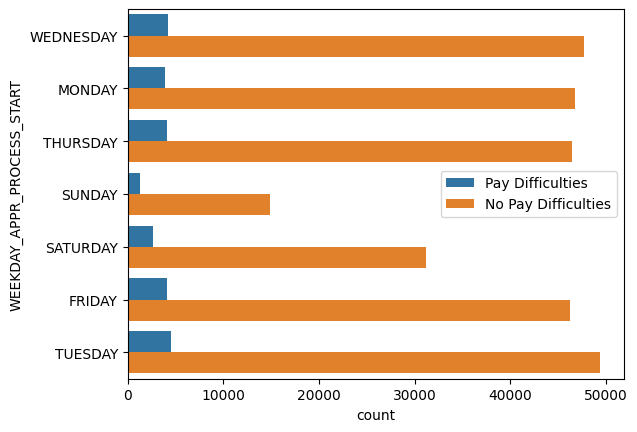

In [534]:
sns.countplot(data=df_train_trgt, y='WEEKDAY_APPR_PROCESS_START', hue='TARGET')
plt.legend(loc='center right')

In [535]:
df_train[['WEEKDAY_APPR_PROCESS_START','TARGET']].groupby(['WEEKDAY_APPR_PROCESS_START'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,WEEKDAY_APPR_PROCESS_START,TARGET
5,TUESDAY,0.084
6,WEDNESDAY,0.082
0,FRIDAY,0.081
4,THURSDAY,0.081
3,SUNDAY,0.079
2,SATURDAY,0.079
1,MONDAY,0.078


##### 13 **Organization Type VS Target**

In [536]:
org_type = df_train_trgt.groupby(by=['TARGET','ORGANIZATION_TYPE'], as_index=False)['SK_ID_CURR'].count()
org_type['%'] = (org_type['SK_ID_CURR']/org_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
org_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,ORGANIZATION_TYPE,SK_ID_CURR,%
5,No Pay Difficulties,Business Entity Type 3,61669,20.050
57,No Pay Difficulties,XNA,52384,17.030
42,No Pay Difficulties,Self-employed,34504,11.220
33,No Pay Difficulties,Other,15408,5.010
30,No Pay Difficulties,Medicine,10456,3.400
...,...,...,...,...
73,Pay Difficulties,Industry: type 10,7,0.000
95,Pay Difficulties,Religion,5,0.000
83,Pay Difficulties,Industry: type 8,3,0.000
107,Pay Difficulties,Trade: type 5,3,0.000


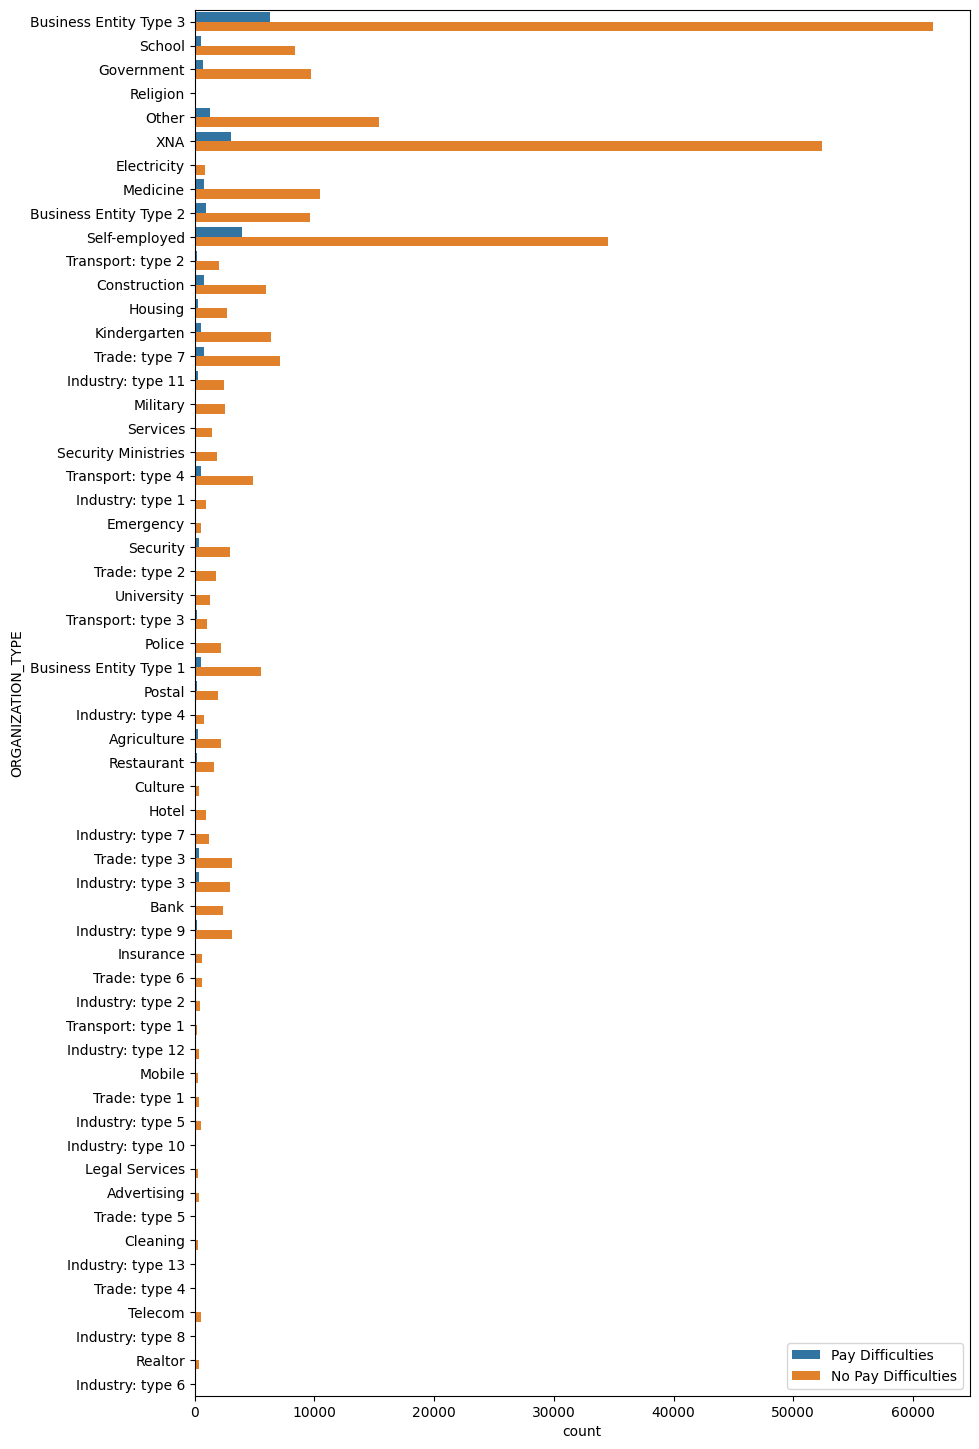

In [537]:
plt.figure(figsize=(10, 18))
sns.countplot(data=df_train_trgt, y='ORGANIZATION_TYPE', hue='TARGET')
plt.legend(loc='lower right')

<Axes: xlabel='count', ylabel='ORGANIZATION_TYPE'>

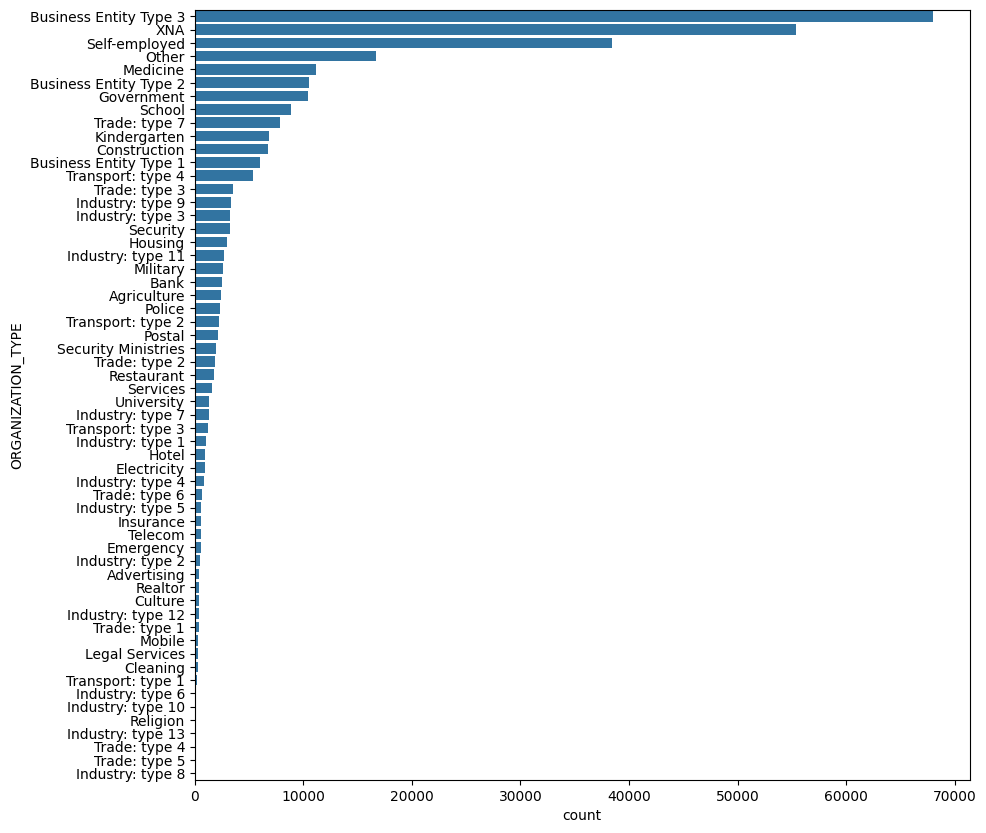

In [538]:
plt.figure(figsize=(10, 10))
sns.countplot(y='ORGANIZATION_TYPE', data = df_train, order=df_train.groupby('ORGANIZATION_TYPE').size().sort_values(ascending=False).index)

**Merge Some Organization Type**

In [539]:
df_train_org = df_train.copy()

In [540]:
categories_to_merge = ['Transport', 'Trade', 'Industry', 'Business Entity']

def replace_categories(value):
    if 'transport' in value.lower():
        return 'Transport'
    elif 'trade' in value.lower():
        return 'Trade'
    elif 'industry' in value.lower():
        return 'Industry'
    elif 'business entity' in value.lower():
        return 'Business Entity'
    return value

# Replace values in the DataFrame
df_train_org['ORGANIZATION_TYPE'] = df_train_org['ORGANIZATION_TYPE'].apply(replace_categories)
df_train_org.groupby('ORGANIZATION_TYPE').size().reset_index(name='count').sort_values(by='count',ascending=False)

,ORGANIZATION_TYPE,count
3,Business Entity,84529
34,XNA,55374
28,Self-employed,38412
19,Other,16683
31,Trade,14315
12,Industry,14311
16,Medicine,11193
9,Government,10404
32,Transport,8990
25,School,8893


In [541]:
org_merge_type = df_train_org.groupby(by=['ORGANIZATION_TYPE'], as_index=False)['SK_ID_CURR'].count()
org_merge_type['%'] = (org_merge_type['SK_ID_CURR']/org_merge_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
org_merge_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,ORGANIZATION_TYPE,SK_ID_CURR,%
3,Business Entity,84529,27.490
34,XNA,55374,18.010
28,Self-employed,38412,12.490
19,Other,16683,5.430
31,Trade,14315,4.660
12,Industry,14311,4.650
16,Medicine,11193,3.640
9,Government,10404,3.380
32,Transport,8990,2.920
25,School,8893,2.890


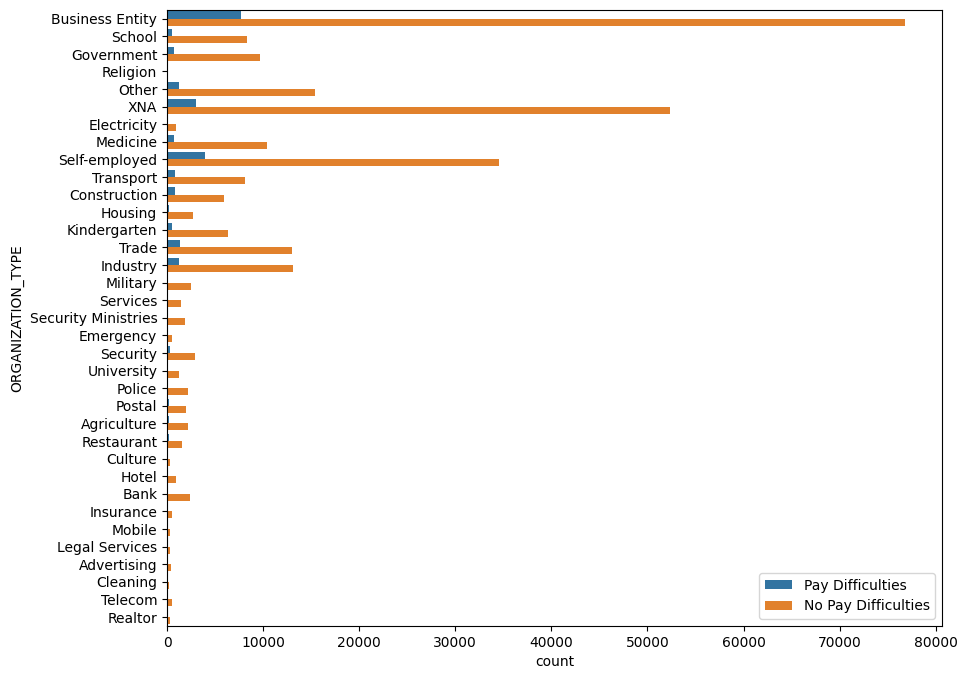

In [542]:
plt.figure(figsize=(10, 8))
df_train_org['TARGET']=df_train_trgt['TARGET']
sns.countplot(data=df_train_org, y='ORGANIZATION_TYPE', hue='TARGET')
plt.legend(loc='lower right')

In [543]:
df_train_org['TARGET']=df_train['TARGET']
df_train_org[['ORGANIZATION_TYPE','TARGET']].groupby(['ORGANIZATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,ORGANIZATION_TYPE,TARGET
24,Restaurant,0.117
5,Construction,0.117
4,Cleaning,0.112
22,Realtor,0.106
1,Agriculture,0.105
28,Self-employed,0.102
26,Security,0.100
32,Transport,0.097
18,Mobile,0.091
3,Business Entity,0.091


##### 14 **Fondkapremont Mode VS Target**

In [544]:
fond_mode = df_train_trgt.groupby(by=['TARGET','FONDKAPREMONT_MODE'], as_index=False)['SK_ID_CURR'].count()
fond_mode['%'] = (fond_mode['SK_ID_CURR']/fond_mode['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
fond_mode.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,FONDKAPREMONT_MODE,SK_ID_CURR,%
2,No Pay Difficulties,reg oper account,68678,70.640
3,No Pay Difficulties,reg oper spec account,11288,11.610
1,No Pay Difficulties,org spec account,5292,5.440
0,No Pay Difficulties,not specified,5258,5.410
6,Pay Difficulties,reg oper account,5152,5.300
7,Pay Difficulties,reg oper spec account,792,0.810
4,Pay Difficulties,not specified,429,0.440
5,Pay Difficulties,org spec account,327,0.340


<Axes: xlabel='count', ylabel='FONDKAPREMONT_MODE'>

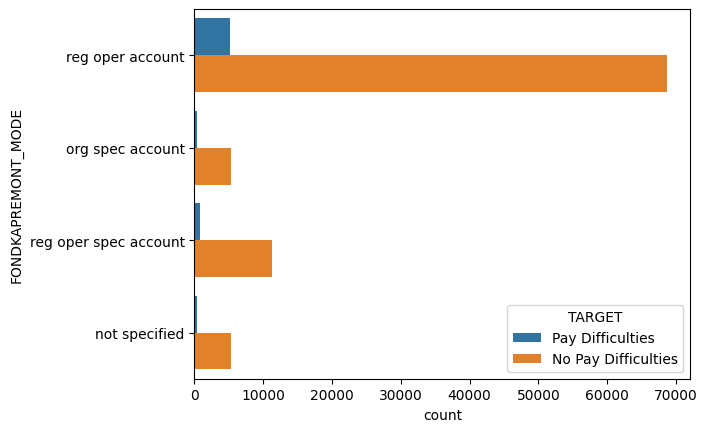

In [545]:
sns.countplot(data=df_train_trgt, y='FONDKAPREMONT_MODE', hue='TARGET')

In [546]:
df_train[['FONDKAPREMONT_MODE','TARGET']].groupby(['FONDKAPREMONT_MODE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FONDKAPREMONT_MODE,TARGET
0,not specified,0.075
2,reg oper account,0.070
3,reg oper spec account,0.066
1,org spec account,0.058


##### 15 **Housetype VS Target**

In [547]:
house_type = df_train_trgt.groupby(by=['TARGET','HOUSETYPE_MODE'], as_index=False)['SK_ID_CURR'].count()
house_type['%'] = (house_type['SK_ID_CURR']/house_type['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
house_type.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,HOUSETYPE_MODE,SK_ID_CURR,%
0,No Pay Difficulties,block of flats,140053,91.410
3,Pay Difficulties,block of flats,10450,6.820
1,No Pay Difficulties,specific housing,1347,0.880
2,No Pay Difficulties,terraced house,1109,0.720
4,Pay Difficulties,specific housing,152,0.100
5,Pay Difficulties,terraced house,103,0.070


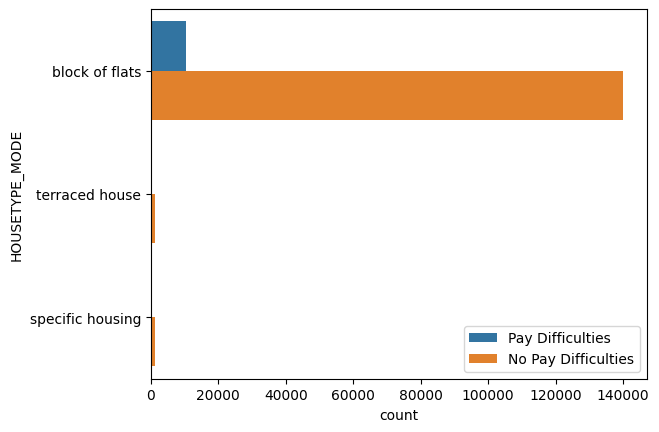

In [548]:
sns.countplot(data=df_train_trgt, y='HOUSETYPE_MODE', hue='TARGET')
plt.legend(loc='lower right')

In [549]:
df_train[['HOUSETYPE_MODE','TARGET']].groupby(['HOUSETYPE_MODE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,HOUSETYPE_MODE,TARGET
1,specific housing,0.101
2,terraced house,0.085
0,block of flats,0.069


##### 16 **Wallsmaterial Mode VS Target**

In [550]:
walls_mat = df_train_trgt.groupby(by=['TARGET','WALLSMATERIAL_MODE'], as_index=False)['SK_ID_CURR'].count()
walls_mat['%'] = (walls_mat['SK_ID_CURR']/walls_mat['SK_ID_CURR'].sum()*100).round(2)
print('Clients Repayment Abilities By Contract Type')
walls_mat.sort_values(by='SK_ID_CURR', ascending=False)

Clients Repayment Abilities By Contract Type


,TARGET,WALLSMATERIAL_MODE,SK_ID_CURR,%
4,No Pay Difficulties,Panel,61848,40.910
5,No Pay Difficulties,"Stone, brick",60015,39.700
0,No Pay Difficulties,Block,8603,5.690
6,No Pay Difficulties,Wooden,4842,3.200
12,Pay Difficulties,"Stone, brick",4800,3.180
11,Pay Difficulties,Panel,4192,2.770
1,No Pay Difficulties,Mixed,2123,1.400
2,No Pay Difficulties,Monolithic,1695,1.120
3,No Pay Difficulties,Others,1490,0.990
7,Pay Difficulties,Block,650,0.430


<Axes: xlabel='count', ylabel='WALLSMATERIAL_MODE'>

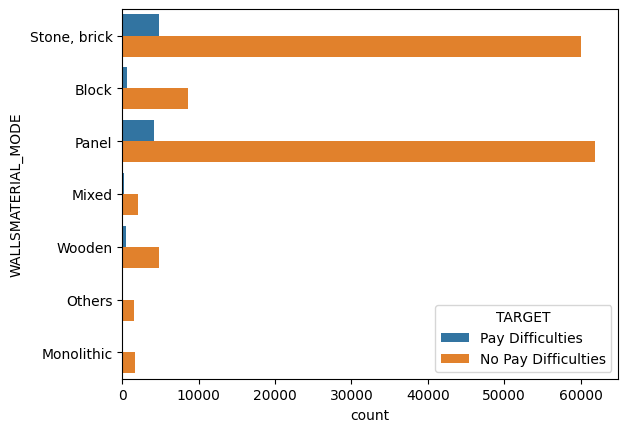

In [551]:
sns.countplot(data=df_train_trgt, y='WALLSMATERIAL_MODE', hue='TARGET')

In [552]:
df_train[['WALLSMATERIAL_MODE','TARGET']].groupby(['WALLSMATERIAL_MODE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,WALLSMATERIAL_MODE,TARGET
6,Wooden,0.097
3,Others,0.083
1,Mixed,0.075
5,"Stone, brick",0.074
0,Block,0.070
4,Panel,0.063
2,Monolithic,0.047


### EDA in Numerical Columns

In [553]:
num = df_train.select_dtypes(include='number').columns

cat_in_num = []
for i in num:
  value_type = df_train[i].value_counts().shape[0]
  if value_type<4:
    cat_in_num.append(i)

num = [x for x in num if x not in cat_in_num]

print('There are',len(num),'columns having numerical values')
print('There are',len(cat_in_num),'columns with less than 10 categories')

There are 71 columns having numerical values
There are 35 columns with less than 10 categories


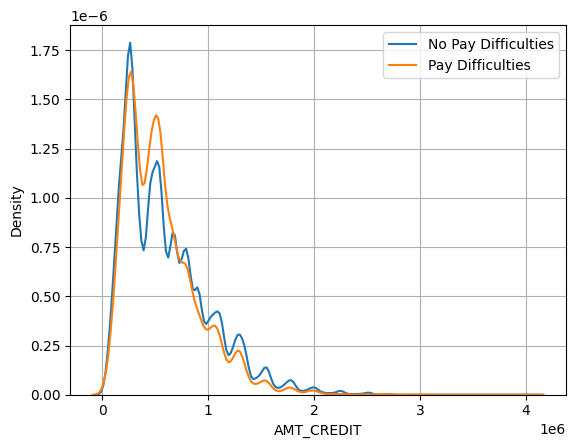

In [554]:
#plt.figure(figsize=(20,10))
sns.kdeplot(x='AMT_CREDIT', data=df_train_trgt[df_train_trgt['TARGET']=='No Pay Difficulties'],label='No Pay Difficulties')
sns.kdeplot(x='AMT_CREDIT', data=df_train_trgt[df_train_trgt['TARGET']=='Pay Difficulties'],label='Pay Difficulties')
plt.legend()
plt.grid()
plt.show()

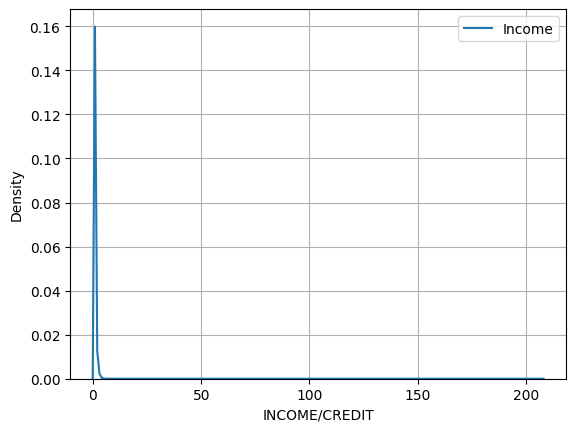

In [555]:
income_credit_ratio = (df_train['AMT_INCOME_TOTAL']/df_train['AMT_CREDIT']).reset_index(name='INCOME/CREDIT')
sns.kdeplot(x='INCOME/CREDIT', data=income_credit_ratio, label='Income')
plt.legend()
plt.grid()
plt.show()

#### Age

In [556]:
no_age = df_train[df_train['TARGET']==0]['DAYS_BIRTH'].values/-365
yes_age = df_train[df_train['TARGET']==1]['DAYS_BIRTH'].values/-365

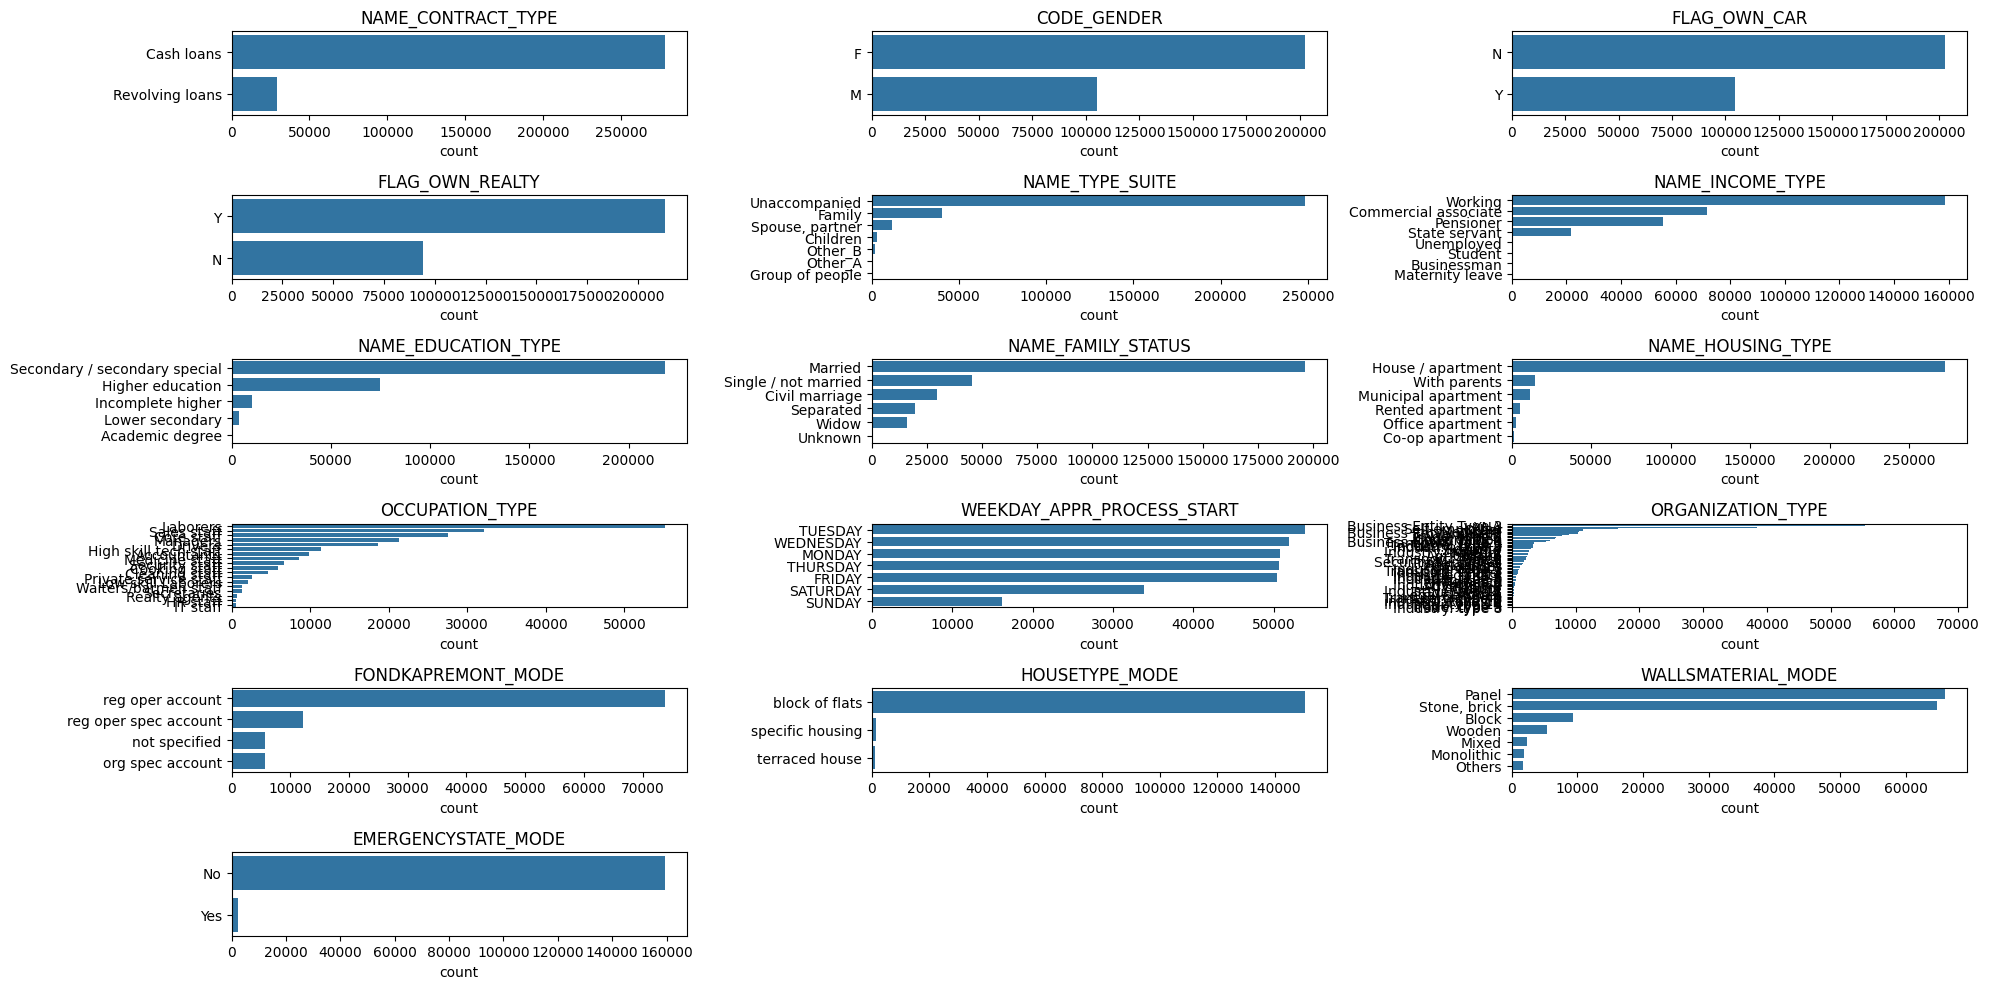

In [557]:
plt.figure(figsize=(20,10))
for i in range(0,len(cat)):
    plt.subplot(6,3,i+1)
    large_to_small = df_train.groupby(cat[i]).size().sort_values().index[::-1]
    sns.countplot(y=df_train[cat[i]], order=large_to_small,orient = 'h').set(ylabel='')
    plt.title(cat[i])
    plt.tight_layout()

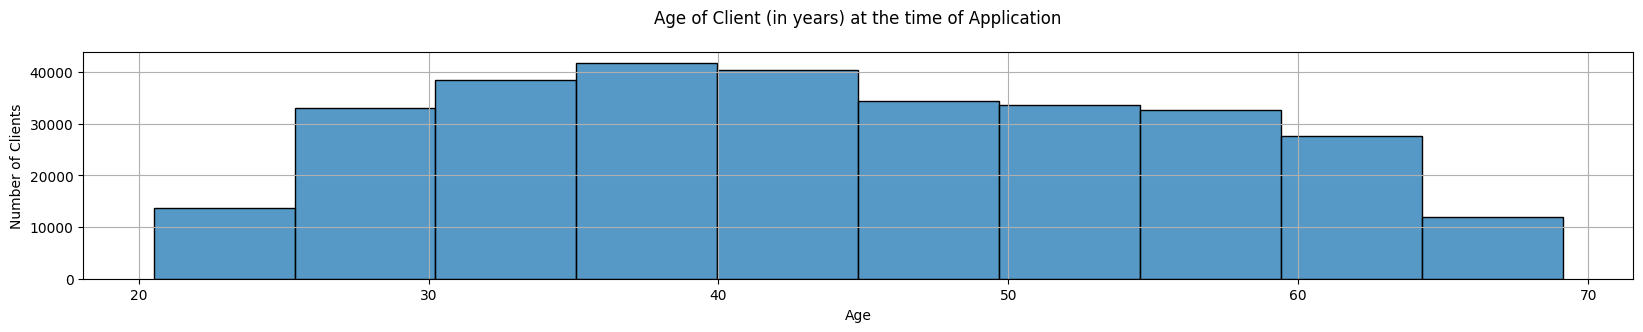

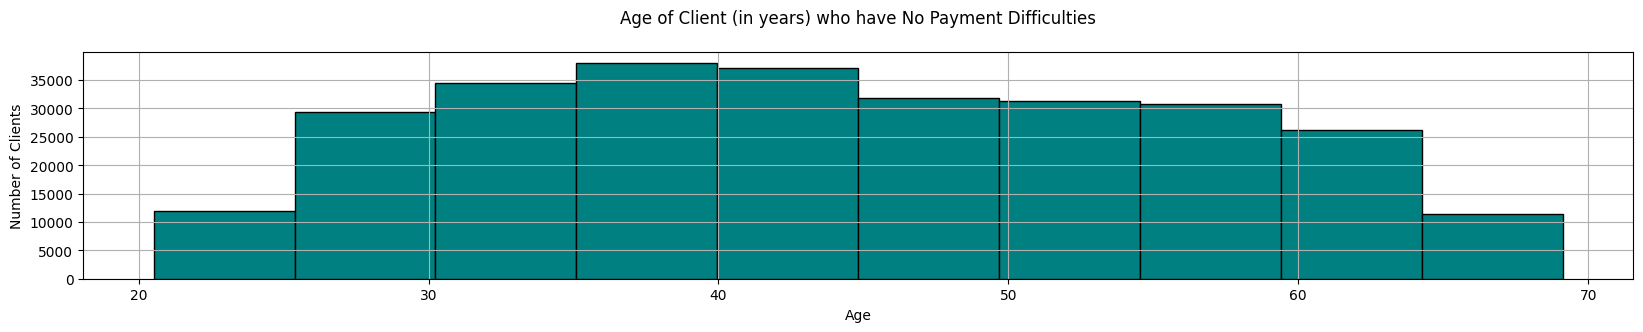

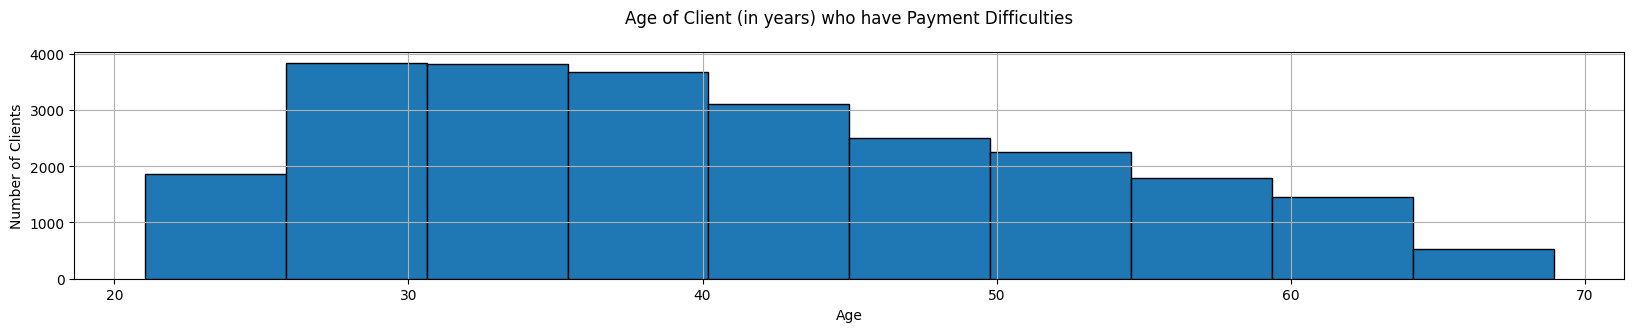

In [558]:
plt.figure(figsize=(20,10))

plt.subplot(3,1,1)
sns.histplot(df_train['DAYS_BIRTH'].values/-365, bins=10, edgecolor='black')
plt.title('Age of Client (in years) at the time of Application\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.grid()
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(3,1,2)
plt.hist(no_age, bins=10, edgecolor='black', color='teal')
plt.title('Age of Client (in years) who have No Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.grid()
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(3,1,3)
plt.hist(yes_age, bins=10, edgecolor='black')
plt.title('Age of Client (in years) who have Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.grid()
plt.show()

#### AMT

(array([2.64426e+05, 4.16390e+04, 1.41500e+03, 3.10000e+01]),
 array([  45000., 1046250., 2047500., 3048750., 4050000.]),
 <BarContainer object of 4 artists>)

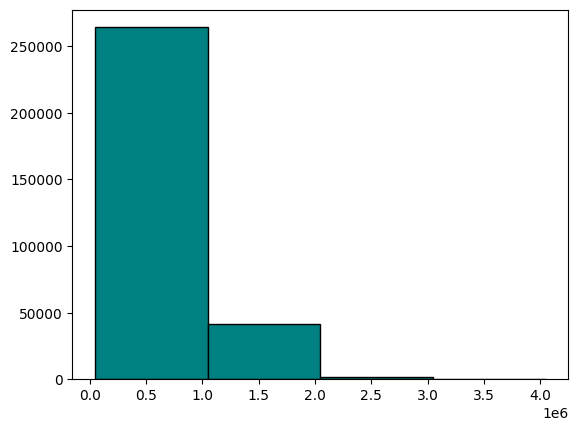

In [559]:
plt.hist(df_train['AMT_CREDIT'], bins=4, edgecolor='black', color='teal')

(array([3.0751e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.565000e+04, 2.342052e+07, 4.681539e+07, 7.021026e+07,
        9.360513e+07, 1.170000e+08]),
 <BarContainer object of 5 artists>)

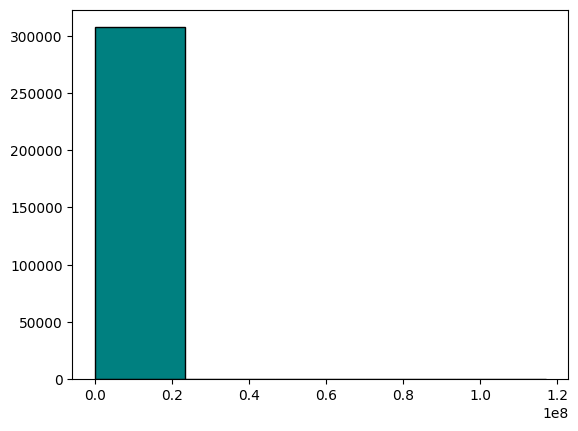

In [560]:
plt.hist(df_train['AMT_INCOME_TOTAL'], bins=5, edgecolor='black', color='teal')

In [561]:
df_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [562]:
print(df_train['TARGET'][df_train['AMT_GOODS_PRICE']>df_train['AMT_CREDIT']].value_counts())

0    247
1     13
Name: TARGET, dtype: int64


In [563]:
print(df_train['TARGET'][df_train['AMT_GOODS_PRICE']<=df_train['AMT_CREDIT']].value_counts())

0    282182
1     24791
Name: TARGET, dtype: int64


In [564]:
print(df_train['TARGET'][df_train['AMT_CREDIT']>df_train['AMT_INCOME_TOTAL']].value_counts())
df_train['TARGET'][df_train['AMT_CREDIT']>df_train['AMT_INCOME_TOTAL']].value_counts()/df_train['TARGET'].value_counts()

0    267553
1     23784
Name: TARGET, dtype: int64


0   0.946
1   0.958
Name: TARGET, dtype: float64

In [565]:
print(df_train['TARGET'][df_train['AMT_CREDIT']<=df_train['AMT_INCOME_TOTAL']].value_counts())
print(df_train['TARGET'][df_train['AMT_CREDIT']<=df_train['AMT_INCOME_TOTAL']].mean())

0    15133
1     1041
Name: TARGET, dtype: int64
0.06436255719055274


In [566]:
credit_month=(df_train['AMT_CREDIT']/df_train['AMT_ANNUITY']).apply(np.ceil).reset_index(name='credit_mth')

In [567]:
credit_month['TARGET']=df_train['TARGET']

In [568]:
credit_month

,index,credit_mth,TARGET
0,0,17.000,1
1,1,37.000,0
2,2,20.000,0
3,3,11.000,0
4,4,24.000,0
...,...,...,...
307506,307506,10.000,0
307507,307507,23.000,0
307508,307508,23.000,0
307509,307509,19.000,1


<Axes: xlabel='credit_mth', ylabel='count'>

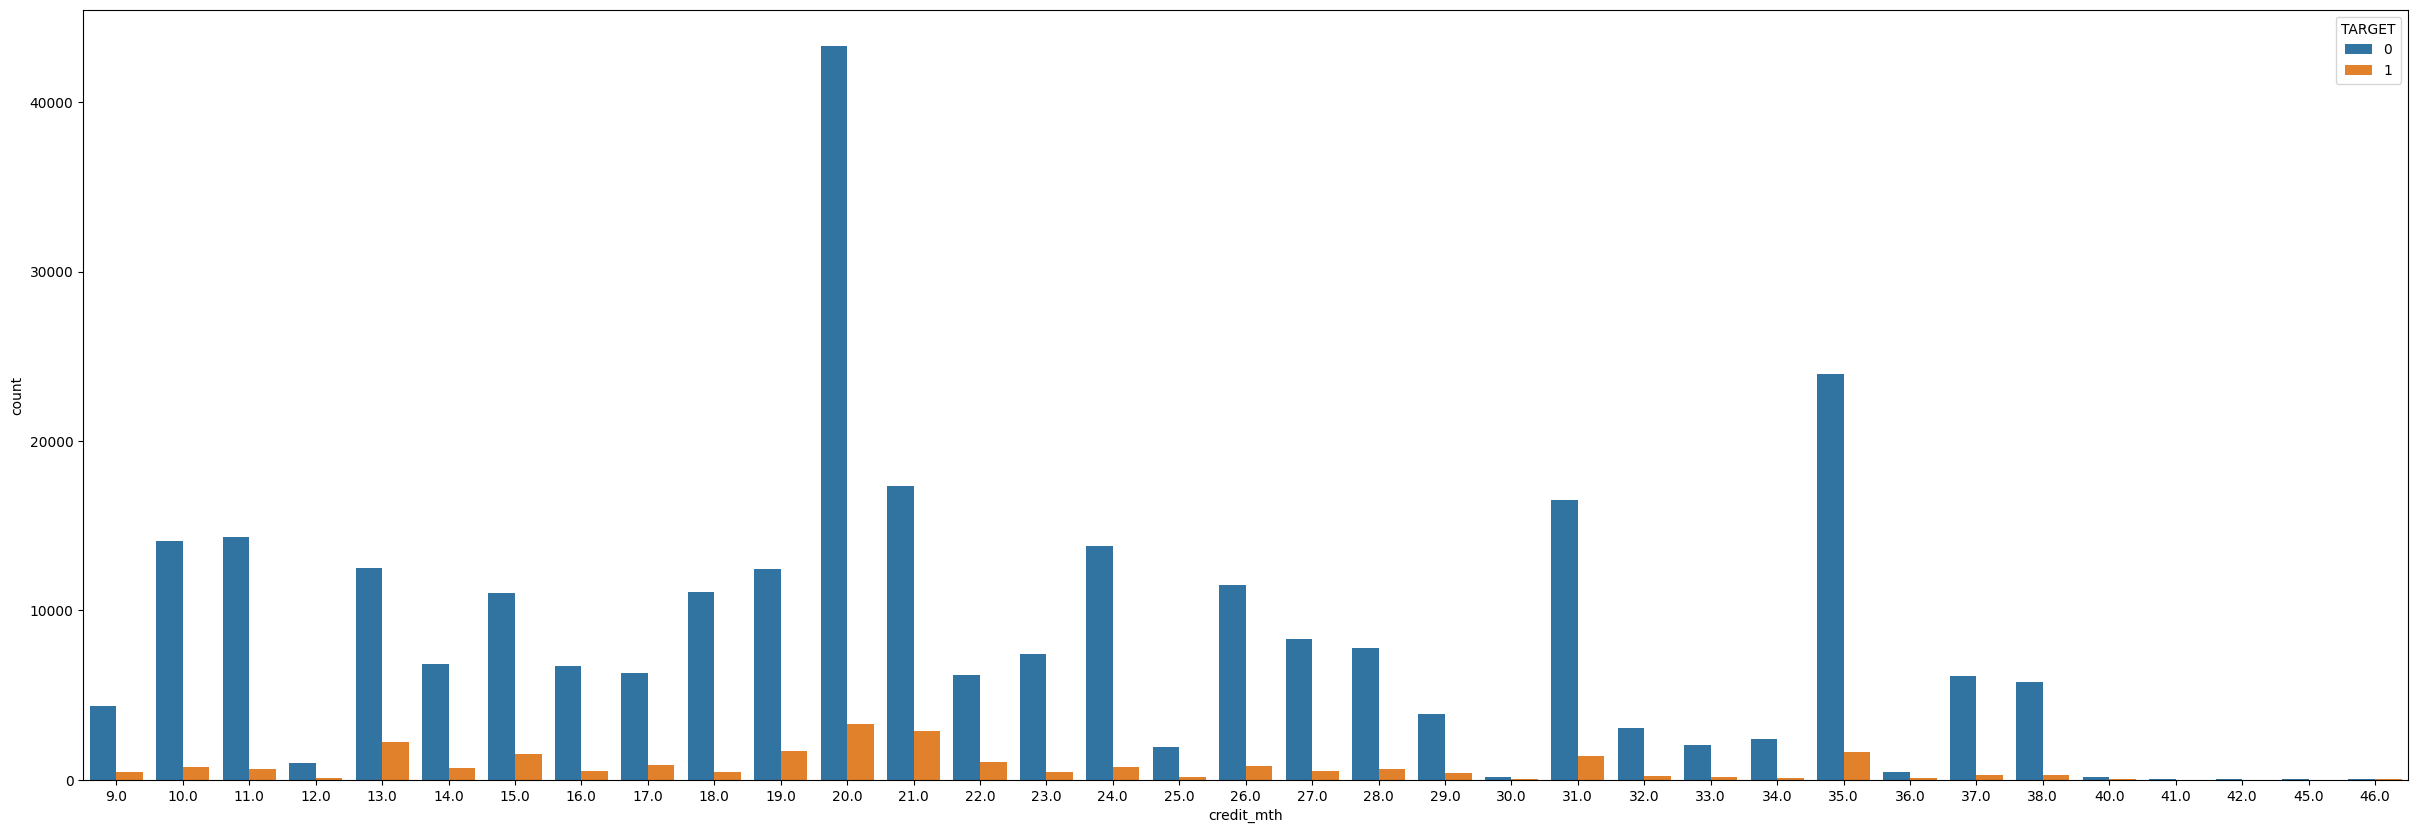

In [569]:
plt.figure(figsize=(30,10))
sns.countplot(data=credit_month, x='credit_mth', hue='TARGET')

(array([3.5695e+04, 4.2022e+04, 7.9394e+04, 3.5244e+04, 3.7696e+04,
        3.0708e+04, 7.9830e+03, 3.8550e+04, 1.9000e+02, 1.7000e+01]),
 array([ 9. , 12.7, 16.4, 20.1, 23.8, 27.5, 31.2, 34.9, 38.6, 42.3, 46. ]),
 <BarContainer object of 10 artists>)

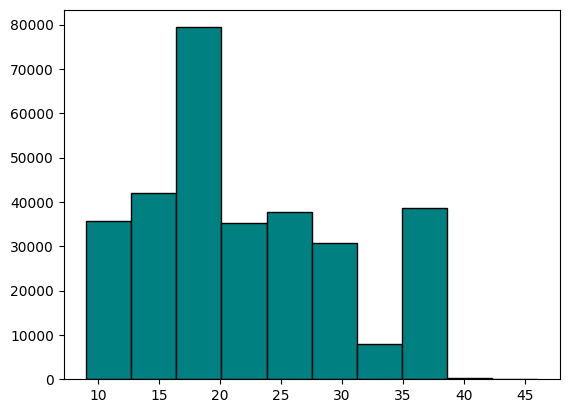

In [570]:
plt.hist(credit_month['credit_mth'], bins=10, edgecolor='black', color='teal')

## Data Cleaning

### Resample (Handling Inbalance)

In [571]:
df_train_v1 = df_train.drop('SK_ID_CURR',axis=1)
df_train_v1.shape

(307511, 121)

In [572]:
class_0 = df_train_v1[df_train_v1['TARGET'] == 0]
class_1 = df_train_v1[df_train_v1['TARGET'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (282686, 121)
class 1: (24825, 121)


In [573]:
df_train_v1.isna().sum().reset_index(name='count').sort_values(by='count',ascending=False)

,index,count
47,COMMONAREA_AVG,214865
61,COMMONAREA_MODE,214865
75,COMMONAREA_MEDI,214865
55,NONLIVINGAPARTMENTS_AVG,213514
69,NONLIVINGAPARTMENTS_MODE,213514
...,...,...
15,REGION_POPULATION_RELATIVE,0
14,NAME_HOUSING_TYPE,0
13,NAME_FAMILY_STATUS,0
12,NAME_EDUCATION_TYPE,0


In [574]:
class_0_under = class_0.sample(class_1.shape[0]+12000,random_state=123)

df_train_v1 = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and 0:\n",df_train_v1['TARGET'].value_counts())
#df_train_v1['TARGET'].value_counts().plot(kind='bar')

total class of 1 and 0:
 0    36825
1    24825
Name: TARGET, dtype: int64


In [575]:
df_train_v1.isna().sum().reset_index(name='count').sort_values(by='count',ascending=False)

,index,count
47,COMMONAREA_AVG,43896
61,COMMONAREA_MODE,43896
75,COMMONAREA_MEDI,43896
55,NONLIVINGAPARTMENTS_AVG,43612
69,NONLIVINGAPARTMENTS_MODE,43612
...,...,...
15,REGION_POPULATION_RELATIVE,0
14,NAME_HOUSING_TYPE,0
13,NAME_FAMILY_STATUS,0
12,NAME_EDUCATION_TYPE,0


### Checking Missing and Negative Values

In [429]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        mis_val_table = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        mis_val_table = mis_val_table[mis_val_table.iloc[:,0]!=0]

        mis_val_table = mis_val_table.sort_values('% of Total Values', ascending=False).round(1)

        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table.shape[0]) +
              " columns that have missing values.")

        return mis_val_table

missing_values = missing_values_table(df_train_v1).reset_index()
missing_values

Your selected dataframe has 121 columns.
There are 66 columns that have missing values.


,index,Missing Values,% of Total Values
0,COMMONAREA_MEDI,43896,71.200
1,COMMONAREA_AVG,43896,71.200
2,COMMONAREA_MODE,43896,71.200
3,NONLIVINGAPARTMENTS_MEDI,43612,70.700
4,NONLIVINGAPARTMENTS_MODE,43612,70.700
...,...,...,...
61,OBS_30_CNT_SOCIAL_CIRCLE,173,0.300
62,EXT_SOURCE_2,146,0.200
63,AMT_GOODS_PRICE,50,0.100
64,CNT_FAM_MEMBERS,1,0.000


In [430]:
miss_val_ge50 = missing_values[missing_values['% of Total Values']>=50]['index'].values
print(miss_val_ge50)
print('Columns with null >50%:',miss_val_ge50.shape)

['COMMONAREA_MEDI' 'COMMONAREA_AVG' 'COMMONAREA_MODE'
 'NONLIVINGAPARTMENTS_MEDI' 'NONLIVINGAPARTMENTS_MODE'
 'NONLIVINGAPARTMENTS_AVG' 'FONDKAPREMONT_MODE' 'LIVINGAPARTMENTS_MODE'
 'LIVINGAPARTMENTS_MEDI' 'LIVINGAPARTMENTS_AVG' 'FLOORSMIN_MODE'
 'FLOORSMIN_MEDI' 'FLOORSMIN_AVG' 'YEARS_BUILD_MODE' 'YEARS_BUILD_MEDI'
 'YEARS_BUILD_AVG' 'OWN_CAR_AGE' 'LANDAREA_AVG' 'LANDAREA_MEDI'
 'LANDAREA_MODE' 'BASEMENTAREA_MEDI' 'BASEMENTAREA_AVG'
 'BASEMENTAREA_MODE' 'EXT_SOURCE_1' 'NONLIVINGAREA_MEDI'
 'NONLIVINGAREA_MODE' 'NONLIVINGAREA_AVG' 'ELEVATORS_MEDI'
 'ELEVATORS_MODE' 'ELEVATORS_AVG' 'WALLSMATERIAL_MODE' 'APARTMENTS_MODE'
 'APARTMENTS_MEDI' 'APARTMENTS_AVG' 'ENTRANCES_MODE' 'ENTRANCES_AVG'
 'ENTRANCES_MEDI' 'HOUSETYPE_MODE' 'LIVINGAREA_MEDI' 'LIVINGAREA_MODE'
 'LIVINGAREA_AVG' 'FLOORSMAX_MEDI' 'FLOORSMAX_AVG' 'FLOORSMAX_MODE'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BEGINEXPLUATATION_MEDI'
 'YEARS_BEGINEXPLUATATION_MODE' 'TOTALAREA_MODE']
Columns with null >50%: (48,)


In [431]:
df_train_v1=df_train_v1.drop(miss_val_ge50,axis=1)
print(df_train_v1.shape)
missing_values_table(df_train_v1).reset_index()

(61650, 73)
Your selected dataframe has 73 columns.
There are 18 columns that have missing values.


,index,Missing Values,% of Total Values
0,EMERGENCYSTATE_MODE,30610,49.700
1,OCCUPATION_TYPE,18013,29.200
2,EXT_SOURCE_3,12820,20.800
3,AMT_REQ_CREDIT_BUREAU_YEAR,9080,14.700
4,AMT_REQ_CREDIT_BUREAU_QRT,9080,14.700
5,AMT_REQ_CREDIT_BUREAU_MON,9080,14.700
6,AMT_REQ_CREDIT_BUREAU_WEEK,9080,14.700
7,AMT_REQ_CREDIT_BUREAU_DAY,9080,14.700
8,AMT_REQ_CREDIT_BUREAU_HOUR,9080,14.700
9,NAME_TYPE_SUITE,221,0.400


#### Columns contain negative value

In [437]:
num_col_neg = df_train_v1.select_dtypes(include='number')
num_col_neg = num_col_neg.columns[num_col_neg.lt(0).any()]
num_col_neg

Index([], dtype='object')

In [438]:
df_train_v1[num_col_neg] = (df_train_v1[num_col_neg].abs()/365).round(2)
df_train_v1[num_col_neg].head()

""
242916
112259
71881
28988
185409


#### Numeric and Categoric columns contain null value

In [439]:
num_col_null = df_train_v1.select_dtypes(include='number')
num_col_null = num_col_null.columns[num_col_null.isnull().any()]
num_col_null

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [440]:
missing_values_table(df_train_v1[num_col_null]).reset_index()

Your selected dataframe has 15 columns.
There are 15 columns that have missing values.


,index,Missing Values,% of Total Values
0,EXT_SOURCE_3,12820,20.800
1,AMT_REQ_CREDIT_BUREAU_HOUR,9080,14.700
2,AMT_REQ_CREDIT_BUREAU_DAY,9080,14.700
3,AMT_REQ_CREDIT_BUREAU_WEEK,9080,14.700
4,AMT_REQ_CREDIT_BUREAU_MON,9080,14.700
5,AMT_REQ_CREDIT_BUREAU_QRT,9080,14.700
6,AMT_REQ_CREDIT_BUREAU_YEAR,9080,14.700
7,OBS_30_CNT_SOCIAL_CIRCLE,173,0.300
8,DEF_30_CNT_SOCIAL_CIRCLE,173,0.300
9,OBS_60_CNT_SOCIAL_CIRCLE,173,0.300


In [441]:
cat_col_null = df_train_v1.select_dtypes(include='object')
cat_col_null = cat_col_null.columns[cat_col_null.isnull().any()]
cat_col_null

Index(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE'], dtype='object')

### Invalid Data and Outliers

In [442]:
cat = df_train_v1.select_dtypes(include='object').columns
num = df_train_v1.select_dtypes(include='number').columns

cat_in_num = []
for i in num:
  value_type = df_train_v1[i].value_counts().shape[0]
  if value_type<4:
    cat_in_num.append(i)

num = [ x for x in num if x not in cat_in_num]
print('colum contain numeric non-categoric shape:',len(num))
print('colum contain categoric-numeric shape:',len(cat_in_num))
print('colum contain categoric-string shape:',len(cat))

colum contain numeric non-categoric shape: 25
colum contain categoric-numeric shape: 35
colum contain categoric-string shape: 13


#### Viz Categorical in Numeric Data

In [443]:
print(cat_in_num)

['TARGET', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


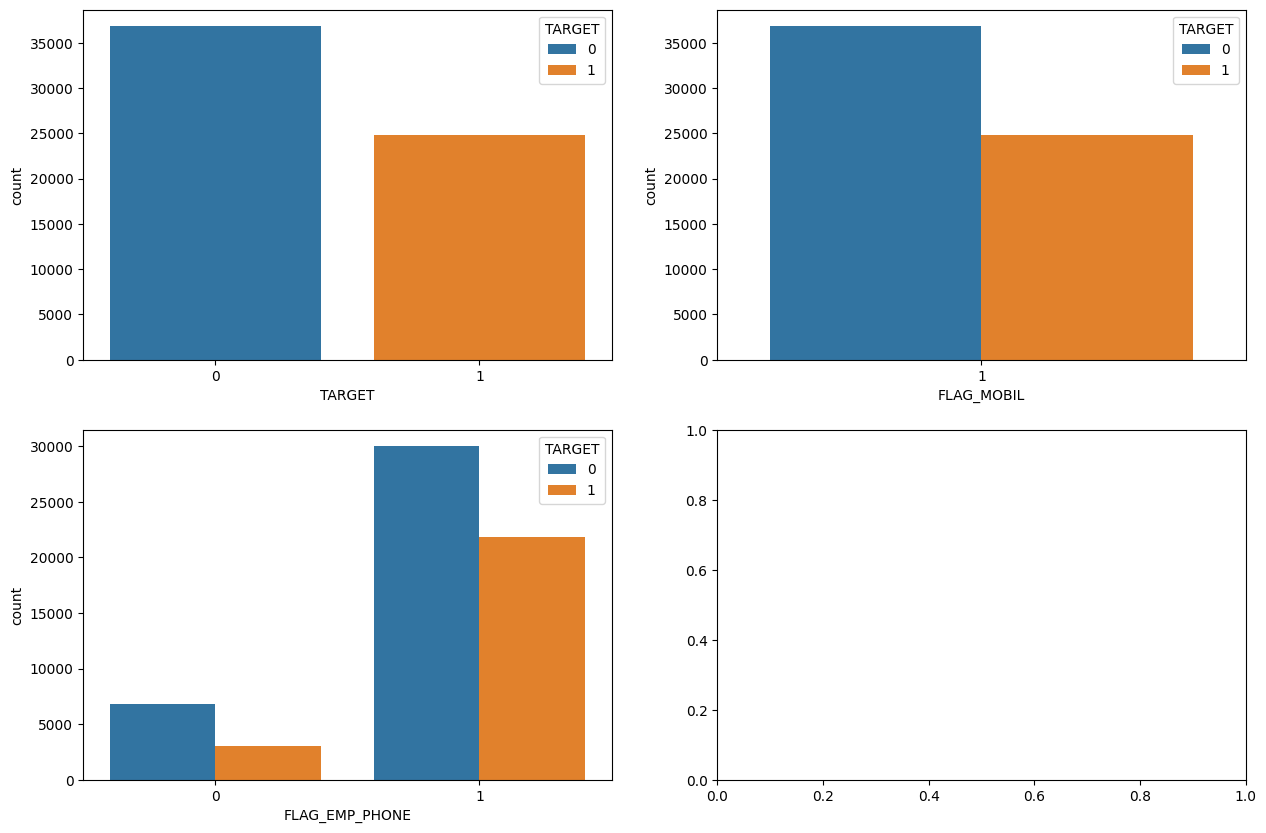

In [444]:
#Outlier in categoric-numeric #1
fig, ax = plt.subplots(2,2, figsize=(15,10))

for i in range(2):
  for j in range(2):
    if (i,j)==(1,1):
      break
    sns.countplot(x=cat_in_num[2*i+j], data = df_train_v1, hue = 'TARGET', ax=ax[i][j])

#### Viz Categoric Data

In [445]:
print(cat)
print(len(cat))

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'EMERGENCYSTATE_MODE'],
      dtype='object')
13


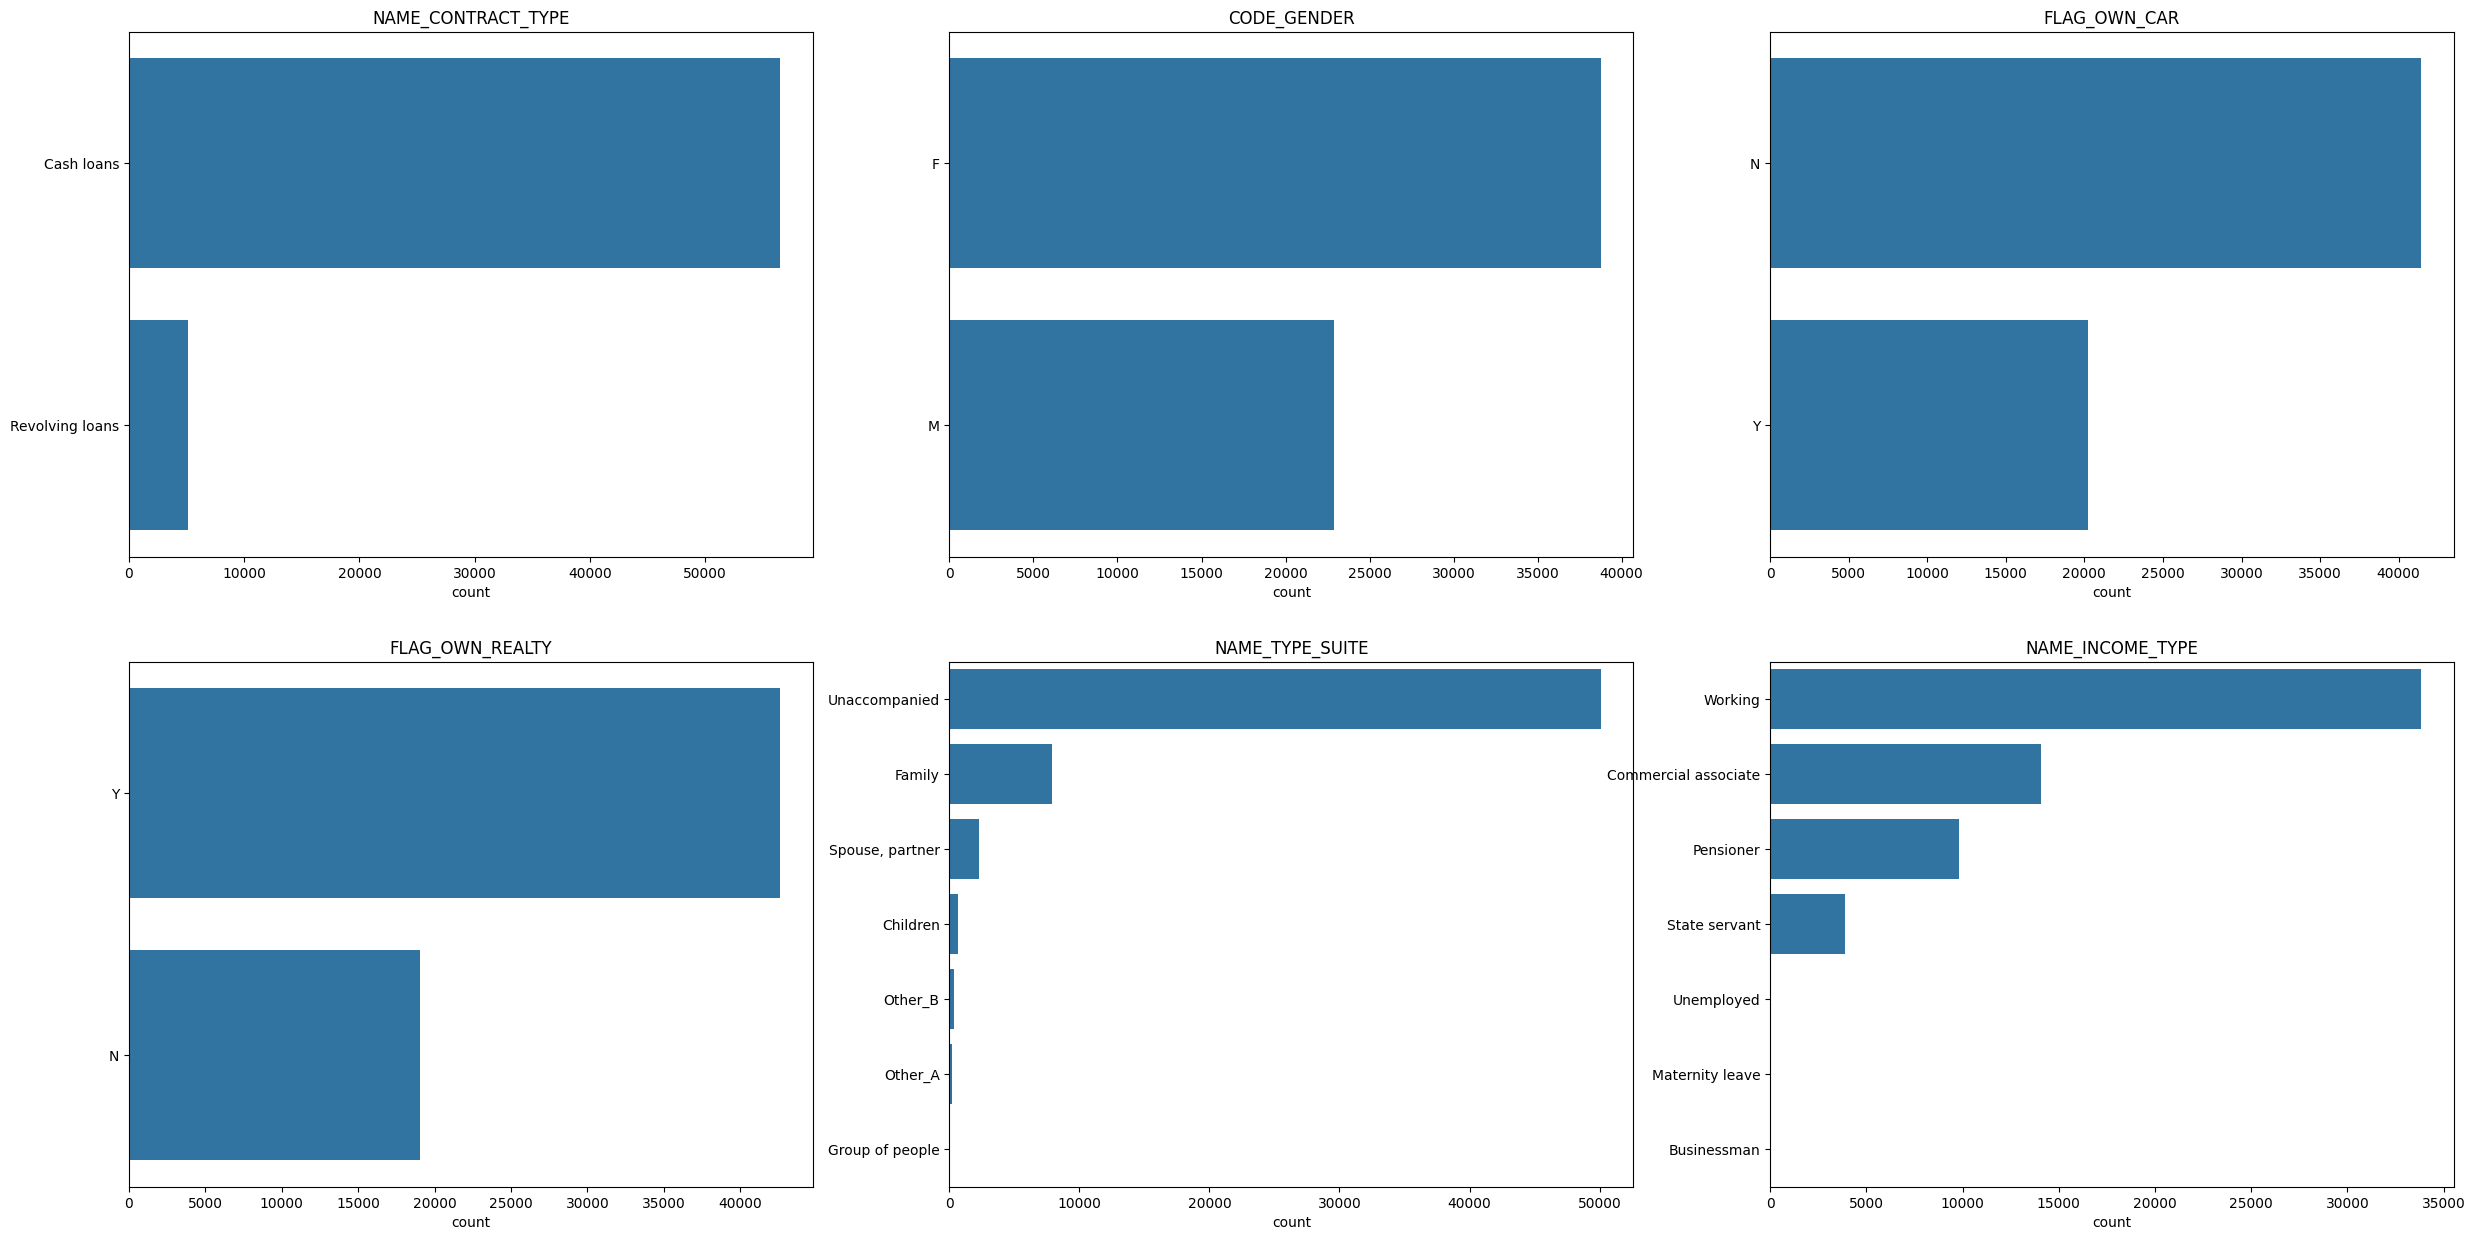

In [446]:
#Outlier in categoric#1
fig, ax = plt.subplots(2,3, figsize=(30,15))

for i in range(2):
  for j in range(3):
    sns.countplot(y=cat[3*i+j], data = df_train_v1, order=df_train_v1.groupby(cat[3*i+j]).size().sort_values(ascending=False).index, ax=ax[i][j])
    ax[i][j].set_ylabel('')
    ax[i][j].set_title(cat[3*i+j])

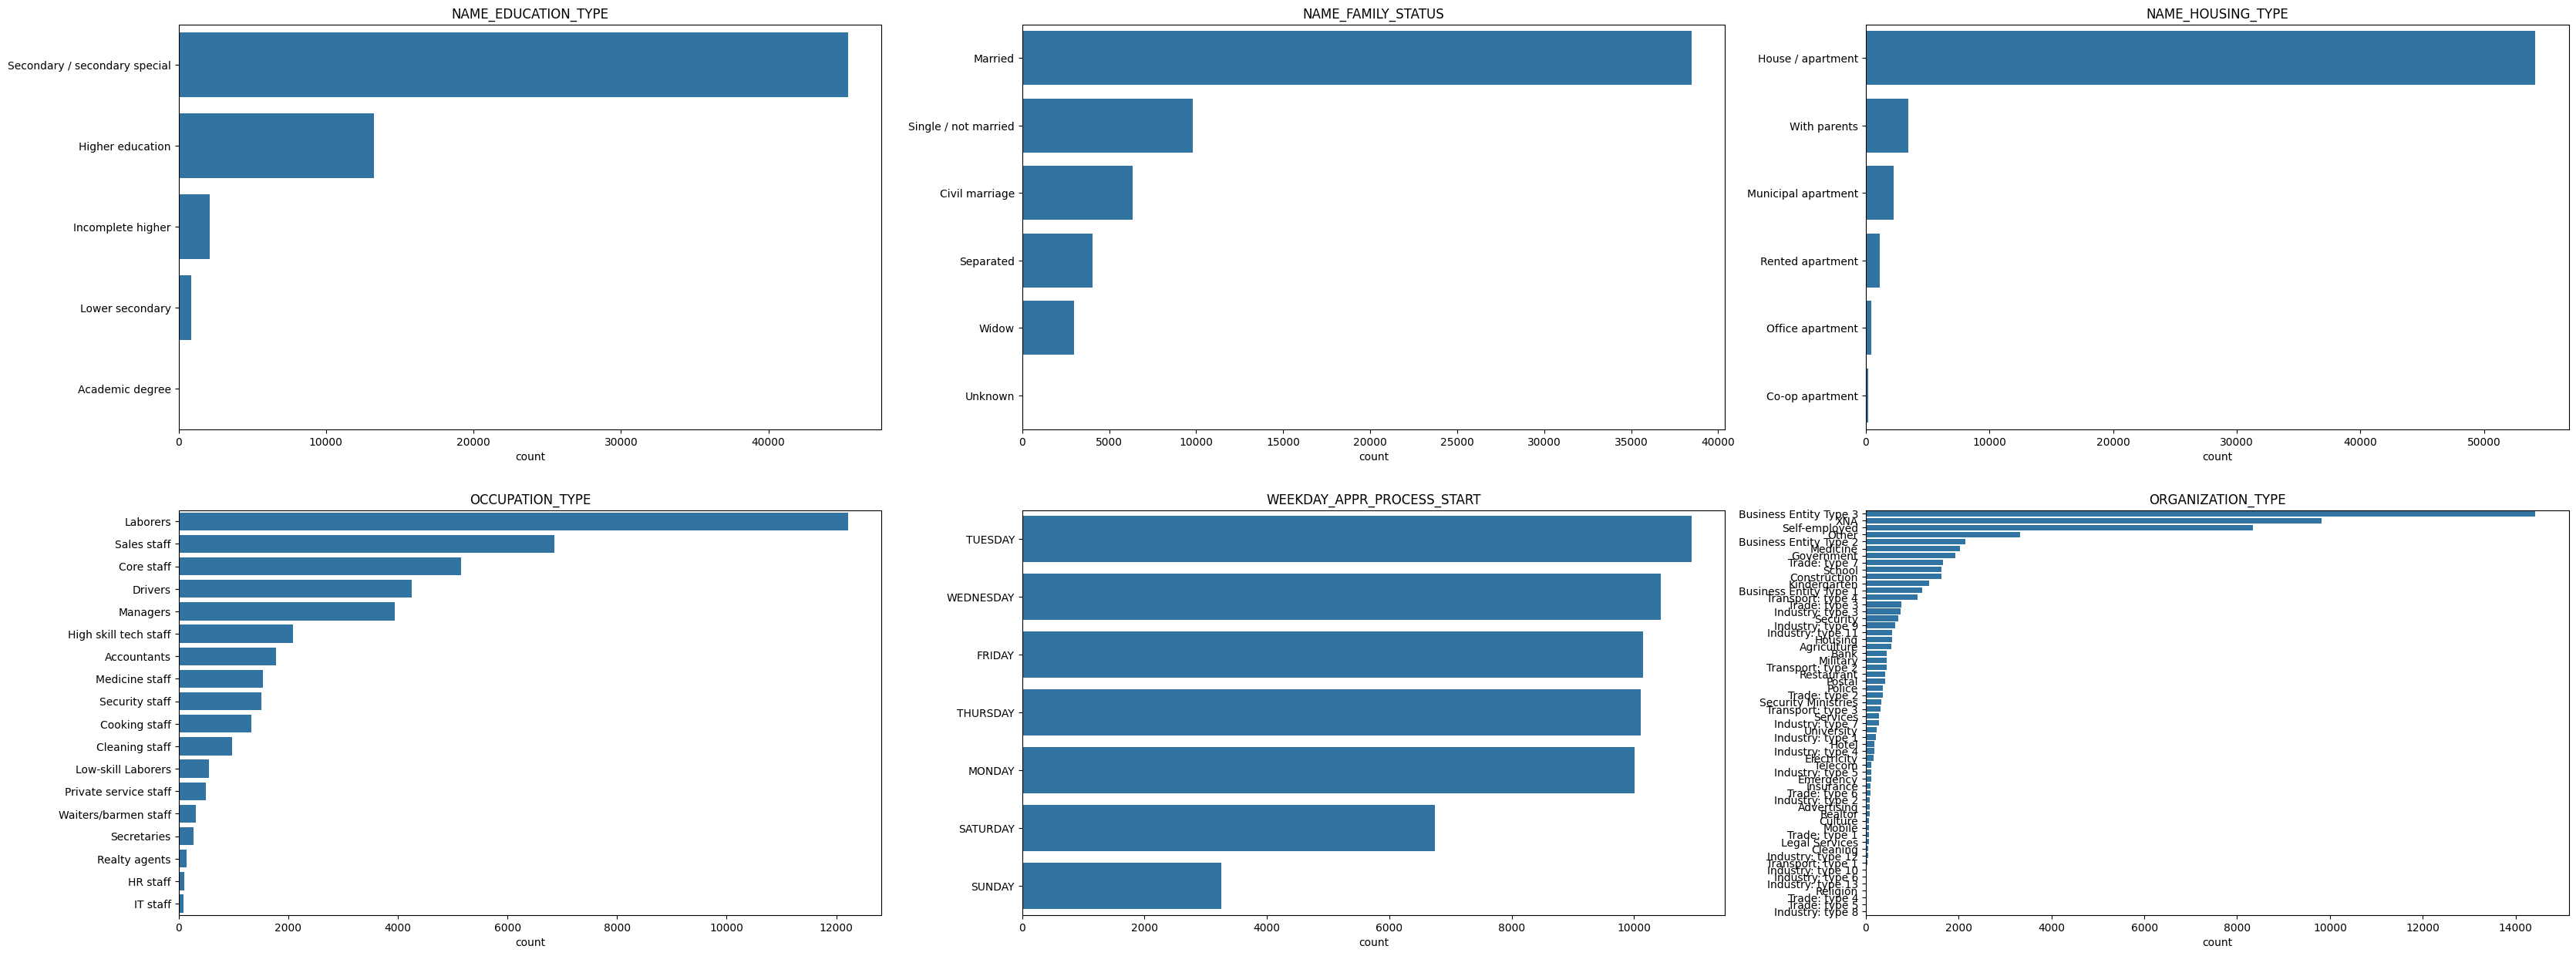

In [447]:
#Outlier in categoric#2
fig, ax = plt.subplots(2,3, figsize=(40,15))

for i in range(2):
  for j in range(3):
    sns.countplot(y=cat[3*i+j+6], data = df_train_v1,order=df_train_v1.groupby(cat[3*i+j+6]).size().sort_values(ascending=False).index, ax=ax[i][j])
    ax[i][j].set_ylabel('')
    ax[i][j].set_title(cat[3*i+j+6])
    if (i,j)==(2,0):
      break


In [448]:
df_train_v1['CODE_GENDER'].replace({'XNA':df_train_v1['CODE_GENDER'].mode()[0]},inplace=True)
df_train_v1['NAME_FAMILY_STATUS'].replace({'Unknown':np.nan},inplace=True)

#df_train_v1['ORGANIZATION_TYPE']=df_train_org['ORGANIZATION_TYPE']
#df_train_v1['ORGANIZATION_TYPE'].replace({'XNA':np.nan},inplace=True)

#### Numeric Data

In [449]:
print(num)

['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [450]:
df_train_v1[num].describe().loc[['min','mean','50%','std','max']]

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
min,0.000,25650.000,45000.000,2052.000,45000.000,0.001,20.520,0.000,0.000,0.000,1.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
mean,0.435,167546.443,584118.651,26893.935,520811.741,0.020,42.867,164.505,13.202,7.950,2.162,11.969,0.479,0.470,1.440,0.159,1.421,0.112,2.498,0.007,0.007,0.033,0.254,0.266,1.940
50%,0.000,144000.000,508495.500,24997.500,450000.000,0.019,41.780,5.180,11.880,8.470,2.000,12.000,0.531,0.485,0.000,0.000,0.000,0.000,1.910,0.000,0.000,0.000,0.000,0.000,2.000
std,0.733,485015.173,383187.894,13777.272,350052.933,0.013,11.903,364.096,9.491,4.168,0.925,3.279,0.205,0.206,2.338,0.470,2.317,0.385,2.218,0.085,0.105,0.198,0.856,0.627,1.898
max,11.000,117000000.000,4050000.000,225000.000,4050000.000,0.073,69.030,1000.670,62.820,17.070,13.000,23.000,0.855,0.896,47.000,6.000,47.000,5.000,11.470,4.000,6.000,6.000,23.000,19.000,22.000


#####**Days Employed Anomaly**

In [451]:
df_train_v1['DAYS_EMPLOYED'].describe()

count   61650.000
mean      164.505
std       364.096
min         0.000
25%         2.280
50%         5.180
75%        13.150
max      1000.670
Name: DAYS_EMPLOYED, dtype: float64

In [452]:
df_train_v1.groupby(by='DAYS_EMPLOYED').size().reset_index(name='count').sort_values(by='count',ascending=False).head()

,DAYS_EMPLOYED,count
3133,1000.670,9824
53,0.530,132
59,0.590,123
61,0.610,120
55,0.550,120


In [453]:
max_dayemploy = df_train_v1['DAYS_EMPLOYED'].max()
anom = df_train_v1[df_train_v1['DAYS_EMPLOYED'] == max_dayemploy]
non_anom = df_train_v1[df_train_v1['DAYS_EMPLOYED'] != max_dayemploy]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 42.13% of loans
The anomalies default on 30.44% of loans
There are 9824 anomalous days of employment


Text(0.5, 0, 'Days Employment')

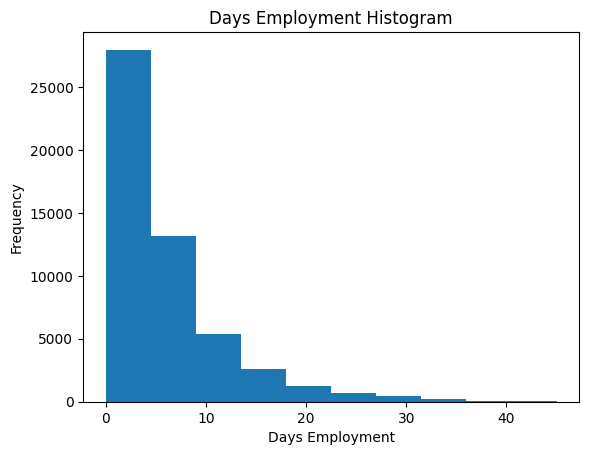

In [454]:
df_train_v1['DAYS_EMPLOYED'].replace({max_dayemploy: np.nan}, inplace = True)

df_train_v1['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

#####**AMT**

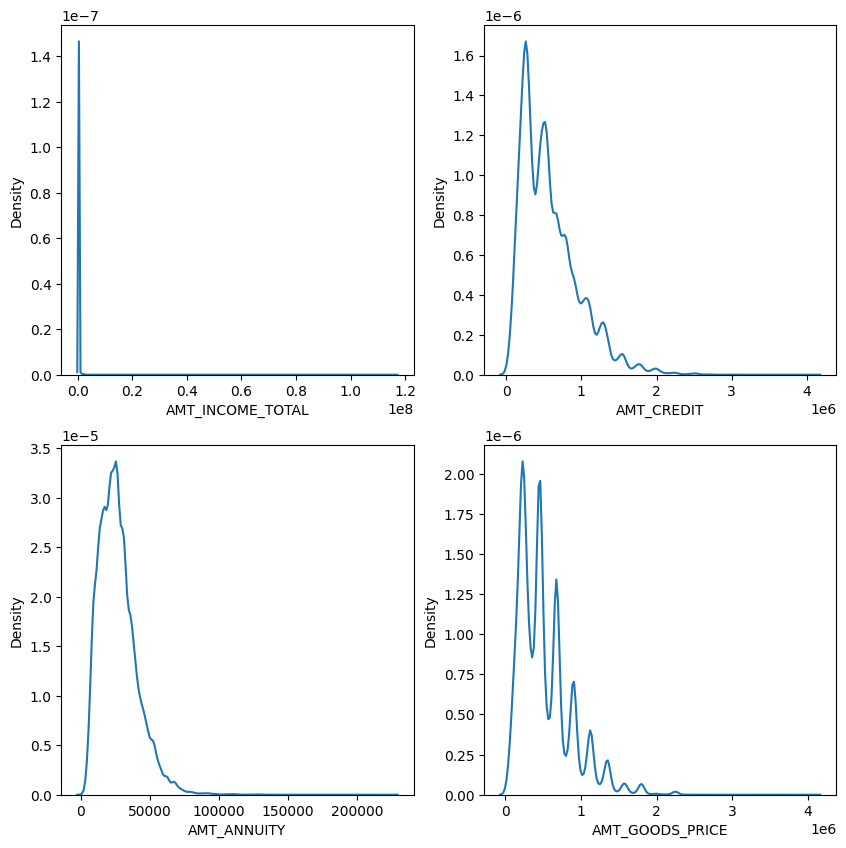

In [455]:
amt = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']
fig, ax = plt.subplots(2,2, figsize=(10,10))

for i in range(2):
  for j in range(2):
    sns.kdeplot(x=amt[2*i+j], data = df_train_v1,ax=ax[i][j])

In [456]:
for i in range(len(amt)):
  print(df_train_v1.groupby(amt[i]).size().reset_index(name='count').sort_values(by=amt[i],ascending=False).head())

     AMT_INCOME_TOTAL  count
824     117000000.000      1
823      18000090.000      1
822       3150000.000      1
821       2475000.000      1
820       2250000.000      3
      AMT_CREDIT  count
3575 4050000.000      1
3574 4027680.000      1
3573 3860019.000      1
3572 3375000.000      1
3571 3150000.000      1
      AMT_ANNUITY  count
9260   225000.000      3
9259   213160.500      1
9258   206167.500      1
9257   173704.500      2
9256   173574.000      1
     AMT_GOODS_PRICE  count
564      4050000.000      1
563      3600000.000      1
562      3555000.000      1
561      3375000.000      1
560      3150000.000      1


<Axes: xlabel='AMT_INCOME_TOTAL', ylabel='Density'>

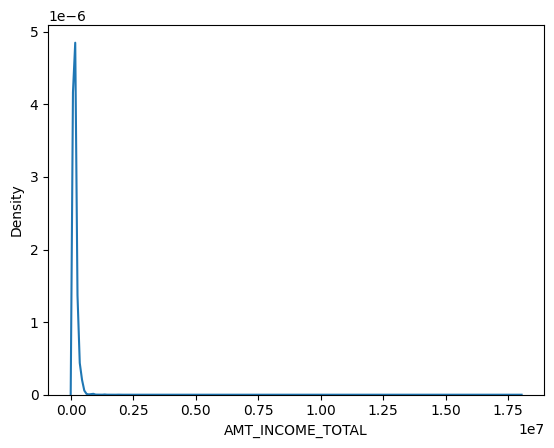

In [457]:
df_train_v1['AMT_INCOME_TOTAL'].replace({117000000: np.nan}, inplace = True)
sns.kdeplot(x='AMT_INCOME_TOTAL', data = df_train_v1)

### Imputation

In [458]:
num_col_null = df_train_v1.select_dtypes(include='number')
num_col_null = num_col_null.columns[num_col_null.isnull().any()]
num_col_null

Index(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [459]:
cat_col_null = df_train_v1.select_dtypes(include='object')
cat_col_null = cat_col_null.columns[cat_col_null.isnull().any()]
cat_col_null

Index(['NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE',
       'EMERGENCYSTATE_MODE'],
      dtype='object')

In [460]:
# Impute Left and Right Skewed in numeric columns
for i in range(len(num_col_null)):
  if df_train_v1[num_col_null[i]].mean()>df_train_v1[num_col_null[i]].median():
    df_train_v1[num_col_null[i]].fillna(df_train_v1[num_col_null[i]].mean(),inplace=True)
  else:
    df_train_v1[num_col_null[i]].fillna(df_train_v1[num_col_null[i]].median(),inplace=True)

# Impute categoric columns with mode
for i in range(len(cat_col_null)):
  df_train_v1[cat_col_null[i]].fillna(df_train_v1[cat_col_null[i]].mode()[0],inplace=True)

### Data Transformation

In [461]:
df_train_transform = df_train_v1.copy()

##### **Clients Contact**

In [462]:
clients_contact = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']
df_train_transform['FLAG_CONTACT'] = df_train[clients_contact].sum(axis=1)

In [463]:
df_train_transform.drop(clients_contact,axis=1,inplace=True)
df_train_transform.shape

(61650, 68)

##### **Clients Document**

In [464]:
document=[]
for i in range(1,21):
  document.append('FLAG_DOCUMENT_'+str(i+1))

print(document)

['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


In [465]:
df_train_transform['FLAG_DOCUMENT'] = df_train[document].sum(axis=1)
df_train_transform.drop(document,axis=1,inplace=True)
df_train_transform.shape

(61650, 49)

##### **Clients Wrong Address**

In [466]:
address = ['REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']

df_train_transform['FLAG_WRONG_ADDRESS'] = df_train[address].sum(axis=1)
df_train_transform.drop(address,axis=1,inplace=True)
df_train_transform.shape

(61650, 44)

### PCA

In [579]:
df_train_pca = df_train_transform.copy()
df_train_pca.shape

(61650, 44)

In [580]:
BEGINEXPLUATATION = ['YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MODE','YEARS_BEGINEXPLUATATION_MEDI']
FLOORSMAX = ['FLOORSMAX_AVG','FLOORSMAX_MODE','FLOORSMAX_MEDI']
CNT_SOCIAL_CIRCLE = ['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']
CNT_FAM_MEMBERS = ['CNT_FAM_MEMBERS','CNT_CHILDREN']
REGION_RATING_CLIENT = ['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY']
AMT_CREDIT = ['AMT_CREDIT','AMT_GOODS_PRICE']

In [581]:
from sklearn.decomposition import PCA
def PCAs(colom):
  pca = PCA(n_components=len(colom))
  princip_comp = pca.fit_transform(df_train_pca[colom])
  print(pca.explained_variance_ratio_.round(3)*100)
  return princip_comp[:,0]
#principal_df = pd.DataFrame(data=princip_comp, columns=['BEGINEXPLUATATION1','BEGINEXPLUATATION2'])
#principal_df

In [582]:
#df_train_pca['BEGINEXPLUATATION'] = PCAs(BEGINEXPLUATATION)
#df_train_pca['FLOORSMAX'] = PCAs(FLOORSMAX)
df_train_pca['CNT_SOCIAL_CIRCLE'] = PCAs(CNT_SOCIAL_CIRCLE)
df_train_pca['CNT_FAM_MEMBERS'] = PCAs(CNT_FAM_MEMBERS)
df_train_pca['REGION_RATING_CLIENT'] = PCAs(REGION_RATING_CLIENT)
df_train_pca['AMT_CREDIT'] = PCAs(AMT_CREDIT)

[96.9  2.8  0.2  0.1]
[94.4  5.6]
[97.7  2.3]
[99.3  0.7]


In [583]:
df_train_pca.drop(CNT_SOCIAL_CIRCLE+CNT_FAM_MEMBERS+REGION_RATING_CLIENT+AMT_CREDIT,axis=1,inplace=True)

In [584]:
df_train_pca.shape

(61650, 35)

In [585]:
df_train_pca.corr()

,TARGET,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_CONTACT,FLAG_DOCUMENT,FLAG_WRONG_ADDRESS,CNT_SOCIAL_CIRCLE
TARGET,1.000,-0.033,-0.025,-0.070,-0.144,-0.135,-0.079,-0.092,-0.043,-0.273,-0.271,-0.105,0.001,0.008,0.005,-0.022,-0.008,0.035,0.036,0.029,0.076,0.020
AMT_INCOME_TOTAL,-0.033,1.000,0.359,0.135,-0.029,0.032,-0.045,-0.001,0.077,0.127,-0.043,0.056,0.004,0.004,0.002,0.042,0.016,0.026,0.044,0.037,0.058,-0.014
AMT_ANNUITY,-0.025,0.359,1.000,0.109,-0.000,0.050,-0.035,0.003,0.052,0.130,0.035,0.072,0.010,-0.003,0.017,0.036,0.003,-0.018,0.048,0.191,0.039,-0.001
REGION_POPULATION_RELATIVE,-0.070,0.135,0.109,1.000,0.046,0.013,0.060,0.014,0.159,0.197,0.006,0.058,-0.000,-0.003,-0.003,0.067,0.001,0.005,0.043,-0.002,-0.020,-0.005
DAYS_BIRTH,-0.144,-0.029,-0.000,0.046,1.000,0.268,0.323,0.272,-0.076,0.126,0.193,0.107,-0.001,0.004,0.009,0.005,0.017,0.069,-0.338,0.040,-0.229,-0.001
DAYS_EMPLOYED,-0.135,0.032,0.050,0.013,0.268,1.000,0.143,0.089,-0.002,0.110,0.118,0.149,0.001,0.001,-0.001,0.023,-0.004,0.000,0.032,0.026,-0.143,0.014
DAYS_REGISTRATION,-0.079,-0.045,-0.035,0.060,0.323,0.143,1.000,0.104,0.019,0.078,0.101,0.065,0.003,0.005,-0.001,0.006,0.007,0.018,-0.086,-0.003,-0.097,-0.011
DAYS_ID_PUBLISH,-0.092,-0.001,0.003,0.014,0.272,0.089,0.104,1.000,-0.024,0.072,0.126,0.105,0.001,-0.001,-0.001,0.013,0.005,0.029,-0.118,0.046,-0.092,0.013
HOUR_APPR_PROCESS_START,-0.043,0.077,0.052,0.159,-0.076,-0.002,0.019,-0.024,1.000,0.152,-0.035,0.023,-0.020,-0.004,-0.006,0.032,-0.002,-0.029,0.089,-0.010,0.052,-0.009
EXT_SOURCE_2,-0.273,0.127,0.130,0.197,0.126,0.110,0.078,0.072,0.152,1.000,0.134,0.220,-0.004,-0.003,0.005,0.050,0.000,-0.019,0.024,-0.002,-0.062,-0.011


## Machine Learning Model

### One-Hot & Label Encoding

In [586]:
df_train_v2 = df_train_pca.copy()
df_train_v2.shape

(61650, 35)

In [587]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0
label_encoded_col = []

for col in df_train_v2:
    if df_train_v2[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_train_v2[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_train_v2[col])
            # Transform both training and testing data
            df_train_v2[col] = le.transform(df_train_v2[col])
            # df1_test[col] = le.transform(df1_test[col])

            # Keep track of how many columns were label encoded
            label_encoded_col.append(col)
            le_count += 1

print('%d columns were label encoded.' % le_count)
print(label_encoded_col)

5 columns were label encoded.
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']


In [588]:
print('Training Features shape before one-hot: ', df_train_v1.shape)

# one-hot encoding of categorical variables
df_train_v2 = pd.get_dummies(df_train_v2)
# df1_test = pd.get_dummies(df_test)

print('Training Features shape: ', df_train_v2.shape)
# print('Testing Features shape: ', df_test.shape)

Training Features shape before one-hot:  (61650, 121)
Training Features shape:  (61650, 140)


In [589]:
df_train_v2.isna().sum().reset_index(name='count').sort_values(by='count',ascending=False)

,index,count
0,TARGET,0
96,ORGANIZATION_TYPE_Industry: type 1,0
90,ORGANIZATION_TYPE_Culture,0
91,ORGANIZATION_TYPE_Electricity,0
92,ORGANIZATION_TYPE_Emergency,0
...,...,...
40,NAME_INCOME_TYPE_Working,0
39,NAME_INCOME_TYPE_Unemployed,0
38,NAME_INCOME_TYPE_State servant,0
37,NAME_INCOME_TYPE_Pensioner,0


In [590]:
# Find correlations with the target and sort
correlations = df_train_v2.corr()['TARGET'].sort_values(ascending=False).reset_index()

# Display correlations
print('Most Positive Correlations:\n', correlations.head(10))
print('\nMost Negative Correlations:\n', correlations.tail(10))

Most Positive Correlations:
                                                index  TARGET
0                                             TARGET   1.000
1                           NAME_INCOME_TYPE_Working   0.106
2                                        CODE_GENDER   0.098
3  NAME_EDUCATION_TYPE_Secondary / secondary special   0.093
4                                 FLAG_WRONG_ADDRESS   0.076
5                    ORGANIZATION_TYPE_Self-employed   0.053
6                            OCCUPATION_TYPE_Drivers   0.051
7                     NAME_HOUSING_TYPE_With parents   0.050
8                 OCCUPATION_TYPE_Low-skill Laborers   0.047
9            NAME_FAMILY_STATUS_Single / not married   0.046

Most Negative Correlations:
                                     index  TARGET
130                     DAYS_REGISTRATION  -0.079
131                 ORGANIZATION_TYPE_XNA  -0.087
132            NAME_INCOME_TYPE_Pensioner  -0.088
133                       DAYS_ID_PUBLISH  -0.092
134                D

### Split Train-Valid

In [592]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def MinMax(X):
  scaler = MinMaxScaler()
  scaler.fit(X)
  return scaler.transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(df_train_v2.drop(columns='TARGET').values, df_train_v2['TARGET'], test_size=0.15, random_state=42)

X_train_std = MinMax(X_train)
X_valid_std = MinMax(X_valid)

print('Train set shape:',X_train_std.shape)
print('Validation set shape:',X_valid_std.shape)

Train set shape: (52402, 139)
Validation set shape: (9248, 139)


### Multi ML Model

In [593]:
from datetime import datetime as dt
from collections import defaultdict
from xgboost import XGBClassifier
import lightgbm as lgb
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, recall_score, precision_score,roc_auc_score, roc_curve, f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

[LightGBM] [Info] Number of positive: 21118, number of negative: 31284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2799
[LightGBM] [Info] Number of data points in the train set: 52402, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.403000 -> initscore=-0.392981
[LightGBM] [Info] Start training from score -0.392981


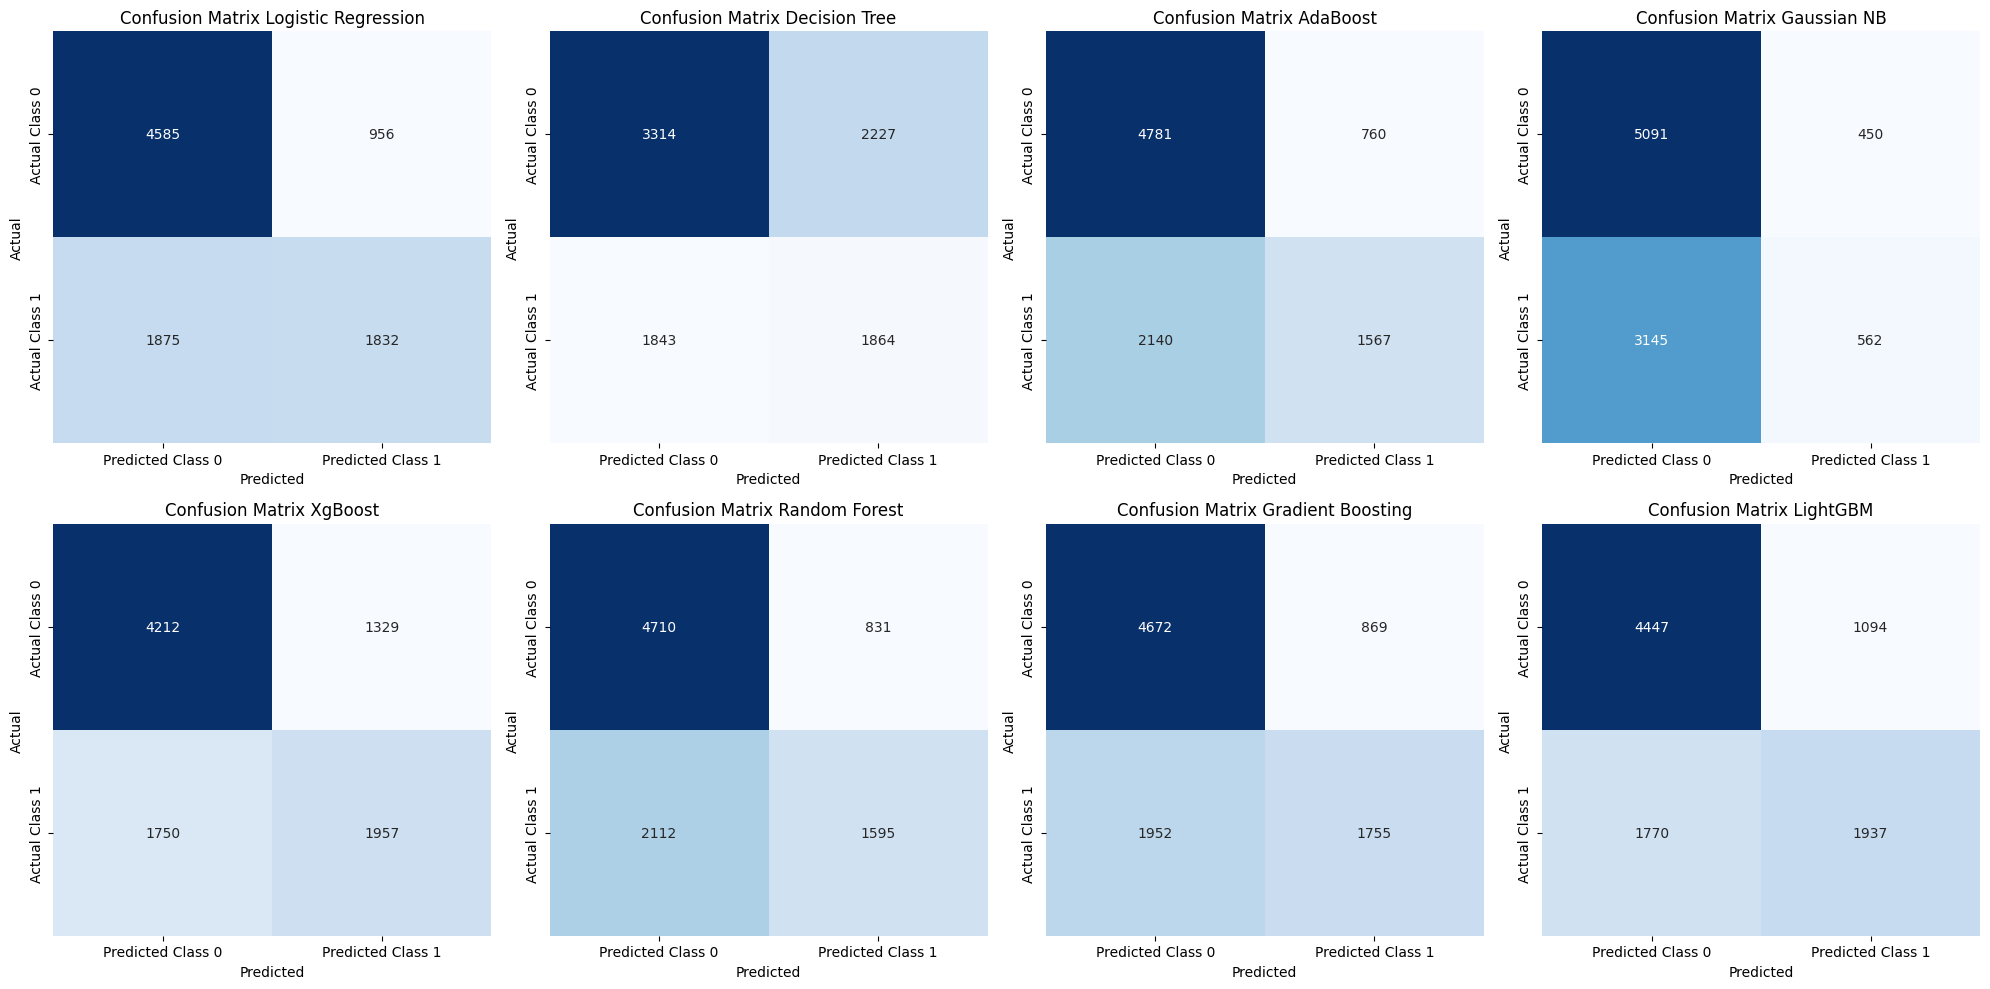

In [607]:
def modelling(x_train,x_test,y_train,y_test):
  result = defaultdict(list)

  lr = LogisticRegression()
  dt = DecisionTreeClassifier()
  ab = AdaBoostClassifier()
  nb = GaussianNB()
  knn = KNeighborsClassifier()
  xgb = XGBClassifier()
  rf = RandomForestClassifier()
  grad = GradientBoostingClassifier()
  LGBM = lgb.LGBMClassifier()


  list_model = [('Logistic Regression',lr),
                ('Decision Tree',dt),
                ('AdaBoost', ab),
                ('Gaussian NB', nb),
                ###('K-Nearest Neighbor',knn),
                ('XgBoost', xgb),
                ('Random Forest',rf),
                ('Gradient Boosting',grad),
                ('LightGBM',LGBM)
                ]

  plt.figure(figsize=(20,10))
  i=0

  for model_name, model in list_model:
      model.fit(x_train,y_train)

      # y_pred_proba = model.predict_proba(x_train)
      # y_pred = model.predict(x_train)

      # accuracy = accuracy_score(y_train,y_pred)
      # recall = recall_score(y_train,y_pred)
      # precision = precision_score(y_train,y_pred)
      # AUC = roc_auc_score(y_train, y_pred_proba[:, 1])

      # result['model_name'].append(model_name)
      # result['model'].append(model)
      # result['accuracy'].append(accuracy)
      # result['recall'].append(recall)
      # result['precision'].append(precision)
      # result['AUC'].append(AUC)

      y_pred_proba = model.predict_proba(x_test)
      y_pred = model.predict(x_test)
      accuracy = accuracy_score(y_test,y_pred)
      error_margin = abs(accuracy-accuracy_score(model.predict(x_train),y_train))
      recall = recall_score(y_test,y_pred)
      precision = precision_score(y_test,y_pred)
      AUC = roc_auc_score(y_test, y_pred_proba[:, 1])

      result['model_name'].append(model_name)
      result['model'].append(model)
      result['accuracy'].append(accuracy)
      result['Error'].append(error_margin)
      result['recall'].append(recall)
      result['precision'].append(precision)
      result['AUC'].append(AUC)

      #print(pd.DataFrame(result))
      cm = confusion_matrix(y_valid, y_pred)

      plt.subplot(2,4,i+1)
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                  xticklabels=['Predicted Class 0', 'Predicted Class 1'],
                  yticklabels=['Actual Class 0', 'Actual Class 1'])
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.title('Confusion Matrix '+model_name)
      plt.tight_layout()
      i=i+1
  return result

evaluation_summary = modelling(X_train_std, X_valid_std, y_train,y_valid)
evaluation_summary = pd.DataFrame(evaluation_summary)

In [608]:
evaluation_summary

,model_name,model,accuracy,Error,recall,precision,AUC
0,Logistic Regression,LogisticRegression(),0.694,0.002,0.494,0.657,0.738
1,Decision Tree,DecisionTreeClassifier(),0.560,0.440,0.503,0.456,0.550
2,AdaBoost,"(DecisionTreeClassifier(max_depth=1, random_st...",0.686,0.005,0.423,0.673,0.724
3,Gaussian NB,GaussianNB(),0.611,0.006,0.152,0.555,0.574
4,XgBoost,"XGBClassifier(base_score=None, booster=None, c...",0.667,0.118,0.528,0.596,0.703
5,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.682,0.318,0.430,0.657,0.722
6,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.695,0.006,0.473,0.669,0.739
7,LightGBM,LGBMClassifier(),0.690,0.036,0.523,0.639,0.730


In [634]:
Grad = GradientBoostingClassifier().fit(X_valid_std,y_valid)

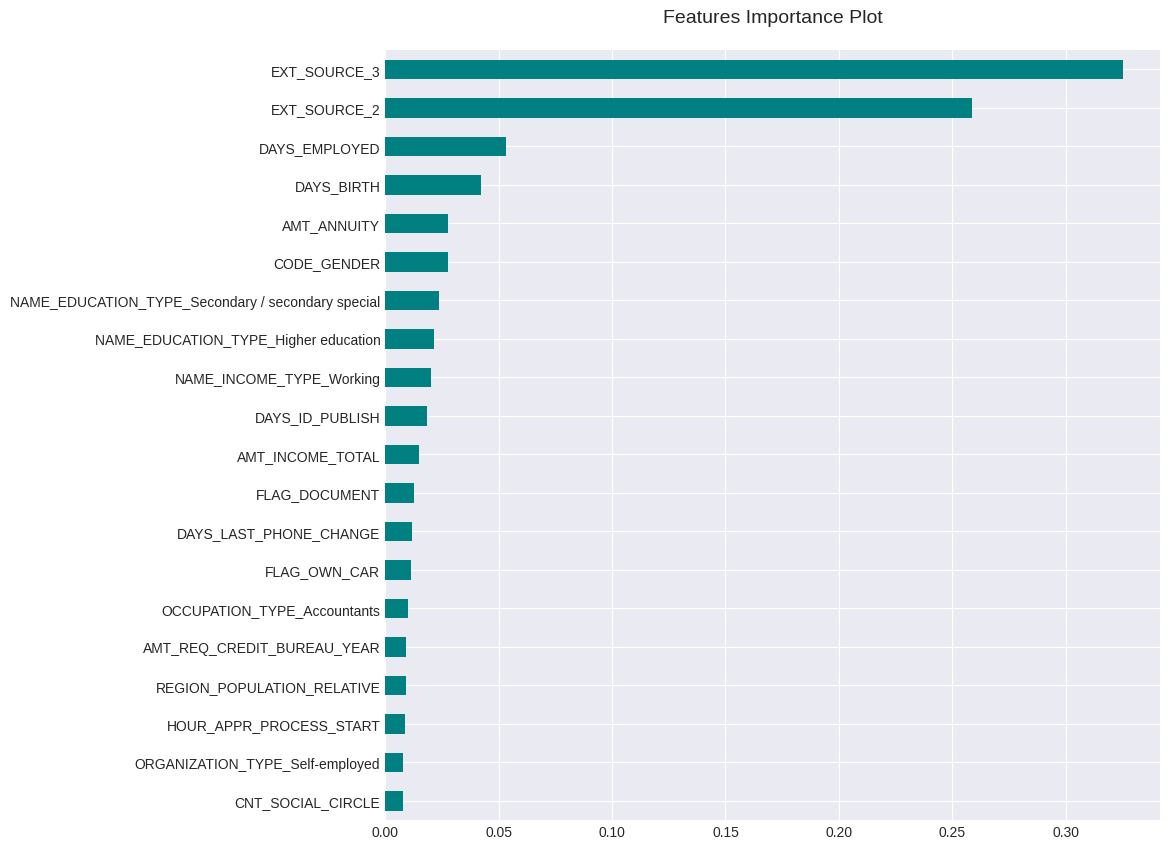

In [635]:
# important features
importances_rf = pd.Series(Grad.feature_importances_, index=df_train_v2.drop(columns='TARGET').columns).sort_values(ascending=True).tail(20)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,10))
fig = importances_rf.plot(kind ='barh', color ='teal')
plt.title('Features Importance Plot\n', fontsize=14)
plt.show()

fig.figure.tight_layout()
fig.figure.savefig('top feature.png')

In [623]:
importances_rf.head()

OCCUPATION_TYPE_Realty agents          0
ORGANIZATION_TYPE_Industry: type 4     0
ORGANIZATION_TYPE_Industry: type 2     0
ORGANIZATION_TYPE_Industry: type 13    0
ORGANIZATION_TYPE_Industry: type 12    0
dtype: int32

### TF Logreg

In [596]:
import tensorflow as tf
import keras
from keras.models import Sequential

model = Sequential([
    tf.keras.layers.Dense(128,'relu',input_shape=(X_train_std.shape[1],)),
    tf.keras.layers.Dense(256,'relu'),
    keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,'sigmoid')

])

In [597]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy',
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc"),
        keras.metrics.AUC(name="prc", curve="PR"),
    ])

history = model.fit(X_train_std,y_train,
                    validation_data=(X_valid_std,y_valid),
                    epochs=20)

Epoch 1/20
1638/1638 [==============================] - 9s 4ms/step - loss: 0.6006 - accuracy: 0.6761 - precision: 0.6316 - recall: 0.4712 - auc: 0.7178 - prc: 0.6237 - val_loss: 0.5906 - val_accuracy: 0.6921 - val_precision: 0.6238 - val_recall: 0.5846 - val_auc: 0.7348 - val_prc: 0.6455
Epoch 2/20
1638/1638 [==============================] - 6s 3ms/step - loss: 0.5895 - accuracy: 0.6878 - precision: 0.6415 - recall: 0.5108 - auc: 0.7341 - prc: 0.6428 - val_loss: 0.5871 - val_accuracy: 0.6916 - val_precision: 0.6560 - val_recall: 0.4850 - val_auc: 0.7374 - val_prc: 0.6496
Epoch 3/20
1638/1638 [==============================] - 6s 4ms/step - loss: 0.5849 - accuracy: 0.6909 - precision: 0.6434 - recall: 0.5227 - auc: 0.7401 - prc: 0.6495 - val_loss: 0.5868 - val_accuracy: 0.6920 - val_precision: 0.6307 - val_recall: 0.5589 - val_auc: 0.7381 - val_prc: 0.6498
Epoch 4/20
1638/1638 [==============================] - 5s 3ms/step - loss: 0.5815 - accuracy: 0.6959 - precision: 0.6499 - recall

In [601]:
X_train_std.shape[1]

139

In [602]:
y_pred = model.predict(X_valid_std)

289/289 [==============================] - 1s 4ms/step


In [603]:
print('Accuracy:', accuracy_score(y_valid,np.round(y_pred)))
print('Recall:', recall_score(y_valid,np.round(y_pred)))
print('Precision:', precision_score(y_valid,np.round(y_pred)))
print('AUC:',roc_auc_score(y_valid,y_pred))

Accuracy: 0.6579801038062284
Recall: 0.5435662260588077
Precision: 0.5780263912794034
AUC: 0.6877673835094563
